# Support Vector Machine (Supervised) Time Series Analysis

This section treats the envisaged dataset as a time series problem. Proposed techniques / methodology here is to:
* Covert the featured label into a discrete column value type, instead of continuous.
* Time Shift the provided datasets with varied 'lag' values.
* Combine all 3 matrices into a agglomorated matrix of 61 + 162 + 1179 features (1402). Duplicate columns ('SNAP_ID') will be reduced to a single one.
* Perform normalization on the data.
* Perform Feature Selction on the dataset by selecting and retaining 1/4 of the total features. (Multivariate analysis - through a Random Forest Ensemble Elimination approach)
* Perform Feature Decomposition on the dataset by decomposing those selected features into a smaller number of components
* Slicing agglomorated matrix into Features/Labels.
* Splitting of train/validation/test set.
* Feed dataset into a number of machine learning models.

A Many to Many approach is opted for in this experiment. The following experiment is trained on a number (greater than 1) of past sequences (t-lag), and all used to train and later predict a number of (t+lag) sequences.

Applicable links:
* https://machinelearningmastery.com/how-to-scale-data-for-long-short-term-memory-networks-in-python/
* https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
* https://machinelearningmastery.com/crash-course-recurrent-neural-networks-deep-learning/
* https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
* https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/
* https://machinelearningmastery.com/diagnose-overfitting-underfitting-lstm-models/

### Module Installation and Importing Libraries

* https://machinelearningmastery.com/setup-python-environment-machine-learning-deep-learning-anaconda/
* https://vertexai-plaidml.readthedocs-hosted.com/en/latest/installing.html

In [1]:
# scipy
import scipy as sc
print('scipy: %s' % sc.__version__)
# numpy
import numpy as np
print('numpy: %s' % np.__version__)
# matplotlib
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
# pandas
import pandas as pd
print('pandas: %s' % pd.__version__)
# statsmodels
import statsmodels
print('statsmodels: %s' % statsmodels.__version__)
# scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_curve, roc_auc_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn import svm
import sklearn as sk
print('sklearn: %s' % sk.__version__)
# math
import math
import csv
import os.path
import time

scipy: 1.1.0
numpy: 1.15.2
pandas: 0.23.4
statsmodels: 0.9.0
sklearn: 0.19.0


### Configuration Cell

Tweak parametric changes from this cell to influence outcome of experiment. 
NB: This experiment demonstrates at time  step = 1 (1 minute in advance). Further down in experiment, other timestep results are also featured and evaluated.

In [2]:
# Experiment Config
tpcds='TPCDS1' # Schema upon which to operate test
lag=2 # Time Series shift / Lag Step. Each lag value equates to 1 minute. Cannot be less than 1
if lag < 1:
    raise ValueError('Lag value must be greater than 1!')
bin_value = 2
nrows=100000
if bin_value < 2:
    raise ValueError('Number of buckets must be greater than 1')
test_split=.2 # Denotes which Data Split to operate under when it comes to training / validation
sub_sample_start=350 # Denotes frist 0..n samples (Used for plotting purposes)
y_label = ['CPU_TIME_DELTA','OPTIMIZER_COST','EXECUTIONS_DELTA','ELAPSED_TIME_DELTA'] # Denotes which label to use for time series experiments

# Feature Selection Config
parallel_degree = 1

# SVM Config
C=1
gamma='auto'
degree=3
kernel='rbf'

### Read data from file into Pandas Dataframes

In [3]:
# Root path
root_dir = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds
#root_dir = 'D:/Projects/Datagenerated_ICS5200/Schedule/' + tpcds

# Open Data
rep_hist_snapshot_path = root_dir + '/rep_hist_snapshot.csv'
rep_hist_sysmetric_summary_path = root_dir + '/rep_hist_sysmetric_summary.csv'
rep_hist_sysstat_path = root_dir + '/rep_hist_sysstat.csv'
# rep_hist_snapshot_path = root_dir + '/v2/rep_hist_snapshot.csv'
# rep_hist_sysmetric_summary_path = root_dir + '/v2/rep_hist_sysmetric_summary.csv'
# rep_hist_sysstat_path = root_dir + '/v2/rep_hist_sysstat.csv'

rep_hist_snapshot_df = pd.read_csv(rep_hist_snapshot_path, nrows=nrows)
rep_hist_sysmetric_summary_df = pd.read_csv(rep_hist_sysmetric_summary_path, nrows=nrows)
rep_hist_sysstat_df = pd.read_csv(rep_hist_sysstat_path, nrows=nrows)

def prettify_header(headers):
    """
    Cleans header list from unwated character strings
    """
    header_list = []
    [header_list.append(header.replace("(","").replace(")","").replace("'","").replace(",","")) for header in headers]
    return header_list

rep_hist_snapshot_df.columns = prettify_header(rep_hist_snapshot_df.columns.values)
rep_hist_sysmetric_summary_df.columns = prettify_header(rep_hist_sysmetric_summary_df.columns.values)
rep_hist_sysstat_df.columns = prettify_header(rep_hist_sysstat_df.columns.values)

print(rep_hist_snapshot_df.columns.values)
print(rep_hist_sysmetric_summary_df.columns.values)
print(rep_hist_sysstat_df.columns.values)

['SNAP_ID' 'DBID' 'INSTANCE_NUMBER' 'SQL_ID' 'PLAN_HASH_VALUE'
 'OPTIMIZER_COST' 'OPTIMIZER_MODE' 'OPTIMIZER_ENV_HASH_VALUE'
 'SHARABLE_MEM' 'LOADED_VERSIONS' 'VERSION_COUNT' 'MODULE' 'ACTION'
 'SQL_PROFILE' 'FORCE_MATCHING_SIGNATURE' 'PARSING_SCHEMA_ID'
 'PARSING_SCHEMA_NAME' 'PARSING_USER_ID' 'FETCHES_TOTAL' 'FETCHES_DELTA'
 'END_OF_FETCH_COUNT_TOTAL' 'END_OF_FETCH_COUNT_DELTA' 'SORTS_TOTAL'
 'SORTS_DELTA' 'EXECUTIONS_TOTAL' 'EXECUTIONS_DELTA'
 'PX_SERVERS_EXECS_TOTAL' 'PX_SERVERS_EXECS_DELTA' 'LOADS_TOTAL'
 'LOADS_DELTA' 'INVALIDATIONS_TOTAL' 'INVALIDATIONS_DELTA'
 'PARSE_CALLS_TOTAL' 'PARSE_CALLS_DELTA' 'DISK_READS_TOTAL'
 'DISK_READS_DELTA' 'BUFFER_GETS_TOTAL' 'BUFFER_GETS_DELTA'
 'ROWS_PROCESSED_TOTAL' 'ROWS_PROCESSED_DELTA' 'CPU_TIME_TOTAL'
 'CPU_TIME_DELTA' 'ELAPSED_TIME_TOTAL' 'ELAPSED_TIME_DELTA' 'IOWAIT_TOTAL'
 'IOWAIT_DELTA' 'CLWAIT_TOTAL' 'CLWAIT_DELTA' 'APWAIT_TOTAL'
 'APWAIT_DELTA' 'CCWAIT_TOTAL' 'CCWAIT_DELTA' 'DIRECT_WRITES_TOTAL'
 'DIRECT_WRITES_DELTA' 'PLSEXEC_TIME_T

### Pivoting Tables and Changing Matrix Shapes

Changes all dataframe shapes to be similar to each other, where in a number of snap_id timestamps are cojoined with instance metrics.

In [4]:
print('Header Lengths [Before Pivot]')
print('REP_HIST_SNAPSHOT: ' + str(len(rep_hist_snapshot_df.columns)))
print('REP_HIST_SYSMETRIC_SUMMARY: ' + str(len(rep_hist_sysmetric_summary_df.columns)))
print('REP_HIST_SYSSTAT: ' + str(len(rep_hist_sysstat_df.columns)))

# Table REP_HIST_SYSMETRIC_SUMMARY
rep_hist_sysmetric_summary_df = rep_hist_sysmetric_summary_df.pivot(index='SNAP_ID', columns='METRIC_NAME', values='AVERAGE')
rep_hist_sysmetric_summary_df.reset_index(inplace=True)
rep_hist_sysmetric_summary_df[['SNAP_ID']] = rep_hist_sysmetric_summary_df[['SNAP_ID']].astype(int)
#rep_hist_sysmetric_summary_df = rep_hist_sysstat_df.groupby(['SNAP_ID']).sum()
rep_hist_sysmetric_summary_df.reset_index(inplace=True)
rep_hist_sysmetric_summary_df.sort_values(by=['SNAP_ID'],inplace=True,ascending=True)

# Table REP_HIST_SYSSTAT
rep_hist_sysstat_df = rep_hist_sysstat_df.pivot(index='SNAP_ID', columns='STAT_NAME', values='VALUE')
rep_hist_sysstat_df.reset_index(inplace=True)
rep_hist_sysstat_df[['SNAP_ID']] = rep_hist_sysstat_df[['SNAP_ID']].astype(int)
#rep_hist_sysstat_df = rep_hist_sysstat_df.groupby(['SNAP_ID']).sum()
rep_hist_sysstat_df.reset_index(inplace=True)
rep_hist_sysstat_df.sort_values(by=['SNAP_ID'],inplace=True,ascending=True)

rep_hist_sysmetric_summary_df.rename(str.upper, inplace=True, axis='columns')
rep_hist_sysstat_df.rename(str.upper, inplace=True, axis='columns')

# Group By Values by SNAP_ID , sum all metrics (for table REP_HIST_SNAPSHOT)
rep_hist_snapshot_df = rep_hist_snapshot_df.groupby(['SNAP_ID','DBID','INSTANCE_NUMBER']).sum()
rep_hist_snapshot_df.reset_index(inplace=True)

print('\nHeader Lengths [After Pivot]')
print('REP_HIST_SNAPSHOT: ' + str(len(rep_hist_snapshot_df.columns)))
print('REP_HIST_SYSMETRIC_SUMMARY: ' + str(len(rep_hist_sysmetric_summary_df.columns)))
print('REP_HIST_SYSSTAT: ' + str(len(rep_hist_sysstat_df.columns)))

# DF Shape
print('\nDataframe shapes:\nTable [REP_HIST_SNAPSHOT] - ' + str(rep_hist_snapshot_df.shape))
print('Table [REP_HIST_SYSMETRIC_SUMMARY] - ' + str(rep_hist_sysmetric_summary_df.shape))
print('Table [REP_HIST_SYSSTAT] - ' + str(rep_hist_sysstat_df.shape))

Header Lengths [Before Pivot]
REP_HIST_SNAPSHOT: 90
REP_HIST_SYSMETRIC_SUMMARY: 26
REP_HIST_SYSSTAT: 16

Header Lengths [After Pivot]
REP_HIST_SNAPSHOT: 77
REP_HIST_SYSMETRIC_SUMMARY: 163
REP_HIST_SYSSTAT: 1180

Dataframe shapes:
Table [REP_HIST_SNAPSHOT] - (1157, 77)
Table [REP_HIST_SYSMETRIC_SUMMARY] - (622, 163)
Table [REP_HIST_SYSSTAT] - (85, 1180)


### Dealing with Empty Values

In [5]:
def get_na_columns(df, headers):
    """
    Return columns which consist of NAN values
    """
    na_list = []
    for head in headers:
        if df[head].isnull().values.any():
            na_list.append(head)
    return na_list

print('N/A Columns\n')
print('\n REP_HIST_SNAPSHOT Features ' + str(len(rep_hist_snapshot_df.columns)) + ': ' + str(get_na_columns(df=rep_hist_snapshot_df,headers=rep_hist_snapshot_df.columns)) + "\n")
print('REP_HIST_SYSMETRIC_SUMMARY Features ' + str(len(rep_hist_sysmetric_summary_df.columns)) + ': ' + str(get_na_columns(df=rep_hist_sysmetric_summary_df,headers=rep_hist_sysmetric_summary_df.columns)) + "\n")
print('REP_HIST_SYSSTAT Features ' + str(len(rep_hist_sysstat_df.columns)) + ': ' + str(get_na_columns(df=rep_hist_sysstat_df,headers=rep_hist_sysstat_df.columns)) + "\n")

def fill_na(df):
    """
    Replaces NA columns with 0s
    """
    return df.fillna(0)

# Populating NaN values with amount '0'
rep_hist_snapshot_df = fill_na(df=rep_hist_snapshot_df)
rep_hist_sysmetric_summary_df = fill_na(df=rep_hist_sysmetric_summary_df)
rep_hist_sysstat_df = fill_na(df=rep_hist_sysstat_df)

N/A Columns


 REP_HIST_SNAPSHOT Features 77: []

REP_HIST_SYSMETRIC_SUMMARY Features 163: ['ACTIVE PARALLEL SESSIONS', 'ACTIVE SERIAL SESSIONS', 'AVERAGE ACTIVE SESSIONS', 'AVERAGE SYNCHRONOUS SINGLE-BLOCK READ LATENCY', 'BACKGROUND CPU USAGE PER SEC', 'BACKGROUND CHECKPOINTS PER SEC', 'BACKGROUND TIME PER SEC', 'BRANCH NODE SPLITS PER SEC', 'BRANCH NODE SPLITS PER TXN', 'CPU USAGE PER SEC', 'CPU USAGE PER TXN', 'CR BLOCKS CREATED PER SEC', 'CR BLOCKS CREATED PER TXN', 'CR UNDO RECORDS APPLIED PER SEC', 'CR UNDO RECORDS APPLIED PER TXN', 'CAPTURED USER CALLS', 'CELL PHYSICAL IO INTERCONNECT BYTES', 'CONSISTENT READ CHANGES PER SEC', 'CONSISTENT READ CHANGES PER TXN', 'CONSISTENT READ GETS PER SEC', 'CONSISTENT READ GETS PER TXN', 'CURRENT LOGONS COUNT', 'CURRENT OS LOAD', 'CURRENT OPEN CURSORS COUNT', 'CURSOR CACHE HIT RATIO', 'DB BLOCK CHANGES PER SEC', 'DB BLOCK CHANGES PER TXN', 'DB BLOCK CHANGES PER USER CALL', 'DB BLOCK GETS PER SEC', 'DB BLOCK GETS PER TXN', 'DB BLOCK GETS PER U

### Merging Frames

This part merges the following pandas data frame into a single frame:
* REP_HIST_SNAPSHOT
* REP_HIST_SYSMETRIC_SUMMARY
* REP_HIST_SYSSTAT

In [6]:
df = pd.merge(rep_hist_snapshot_df, rep_hist_sysmetric_summary_df,how='inner',on ='SNAP_ID')
df = pd.merge(df, rep_hist_sysstat_df,how='inner',on ='SNAP_ID')
print(df.shape)
print('----------------------------------')
print(df.columns.tolist())

(85, 1418)
----------------------------------
['SNAP_ID', 'DBID', 'INSTANCE_NUMBER', 'PLAN_HASH_VALUE', 'OPTIMIZER_COST', 'OPTIMIZER_ENV_HASH_VALUE', 'SHARABLE_MEM', 'LOADED_VERSIONS', 'VERSION_COUNT', 'SQL_PROFILE', 'PARSING_SCHEMA_ID', 'PARSING_USER_ID', 'FETCHES_TOTAL', 'FETCHES_DELTA', 'END_OF_FETCH_COUNT_TOTAL', 'END_OF_FETCH_COUNT_DELTA', 'SORTS_TOTAL', 'SORTS_DELTA', 'EXECUTIONS_TOTAL', 'EXECUTIONS_DELTA', 'PX_SERVERS_EXECS_TOTAL', 'PX_SERVERS_EXECS_DELTA', 'LOADS_TOTAL', 'LOADS_DELTA', 'INVALIDATIONS_TOTAL', 'INVALIDATIONS_DELTA', 'PARSE_CALLS_TOTAL', 'PARSE_CALLS_DELTA', 'DISK_READS_TOTAL', 'DISK_READS_DELTA', 'BUFFER_GETS_TOTAL', 'BUFFER_GETS_DELTA', 'ROWS_PROCESSED_TOTAL', 'ROWS_PROCESSED_DELTA', 'CPU_TIME_TOTAL', 'CPU_TIME_DELTA', 'ELAPSED_TIME_TOTAL', 'ELAPSED_TIME_DELTA', 'IOWAIT_TOTAL', 'IOWAIT_DELTA', 'CLWAIT_TOTAL', 'CLWAIT_DELTA', 'APWAIT_TOTAL', 'APWAIT_DELTA', 'CCWAIT_TOTAL', 'CCWAIT_DELTA', 'DIRECT_WRITES_TOTAL', 'DIRECT_WRITES_DELTA', 'PLSEXEC_TIME_TOTAL', 'PLSEXE

### Data Ordering

Sorting of datasets in order of SNAP_ID.

In [7]:
df.sort_values(by=['SNAP_ID'], ascending=True, inplace=True)
print(df.shape)

(85, 1418)


### Floating point precision conversion

Each column is converted into a column of type values which are floating point for higher precision.

In [8]:
df.astype('float32', inplace=True)
df = np.round(df, 3) # rounds to 3 dp
print(df.shape)

(85, 1418)


### Redundant Feature Removal
In this step, redundant features are dropped. Features are considered redundant if exhibit a standard devaition of 0 (meaning no change in value).

In [9]:
def drop_flatline_columns(df):
    columns = df.columns
    flatline_features = []
    for i in range(len(columns)):
        try:
            std = df[columns[i]].std()
            if std == 0:
                flatline_features.append(columns[i])
        except:
            pass
    
    print('\nShape before changes: [' + str(df.shape) + ']')
    df = df.drop(columns=flatline_features)
    print('Shape after changes: [' + str(df.shape) + ']')
    print('Dropped a total [' + str(len(flatline_features)) + ']')
    return df

print('Before column drop:')
print(df.shape)
df = drop_flatline_columns(df=df)
print('\nAfter flatline column drop:')
print(df.shape)
dropped_columns_df = [ 'PLAN_HASH_VALUE',
                       'OPTIMIZER_ENV_HASH_VALUE',
                       'LOADED_VERSIONS',
                       'VERSION_COUNT',
                       'PARSING_SCHEMA_ID',
                       'PARSING_USER_ID',
                       'CON_DBID',
                       'SNAP_LEVEL',
                       'SNAP_FLAG',
                       'COMMAND_TYPE']
df.drop(columns=dropped_columns_df, inplace=True)
print('\nAfter additional column drop:')
print(df.shape)

Before column drop:
(85, 1418)

Shape before changes: [(85, 1418)]
Shape after changes: [(85, 496)]
Dropped a total [922]

After flatline column drop:
(85, 496)

After additional column drop:
(85, 486)


## Visualizing Labels

https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/

### Histograms

A simple and commonly used plot to quickly check the distribution of a sample of data is the histogram.

In the histogram, the data is divided into a pre-specified number of groups called bins. The data is then sorted into each bin and the count of the number of observations in each bin is retained.

The plot shows the bins across the x-axis maintaining their ordinal relationship, and the count in each bin on the y-axis.

A sample of data has a Gaussian distribution of the histogram plot, showing the familiar bell shape.

### Quantile-Quantile Plot

Another popular plot for checking the distribution of a data sample is the quantile-quantile plot, Q-Q plot, or QQ plot for short.

This plot generates its own sample of the idealized distribution that we are comparing with, in this case the Gaussian distribution. The idealized samples are divided into groups (e.g. 5), called quantiles. Each data point in the sample is paired with a similar member from the idealized distribution at the same cumulative distribution.

The resulting points are plotted as a scatter plot with the idealized value on the x-axis and the data sample on the y-axis.

A perfect match for the distribution will be shown by a line of dots on a 45-degree angle from the bottom left of the plot to the top right. Often a line is drawn on the plot to help make this expectation clear. Deviations by the dots from the line shows a deviation from the expected distribution.

### Shapiro-Wilk Test

The Shapiro-Wilk test evaluates a data sample and quantifies how likely it is that the data was drawn from a Gaussian distribution, named for Samuel Shapiro and Martin Wilk.

In practice, the Shapiro-Wilk test is believed to be a reliable test of normality, although there is some suggestion that the test may be suitable for smaller samples of data, e.g. thousands of observations or fewer.

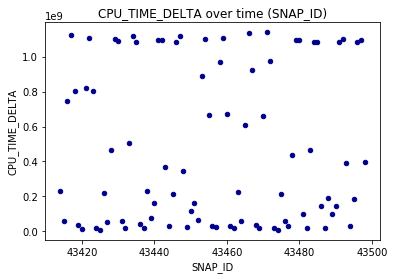

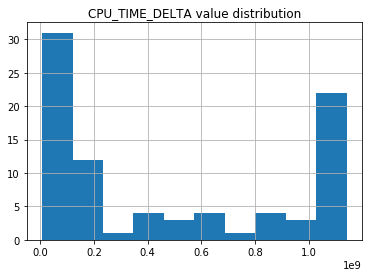

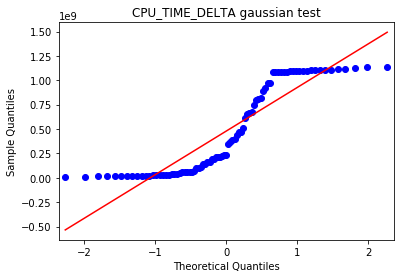

Statistics=0.807, p=0.000
Sample does not look Gaussian (reject H0)


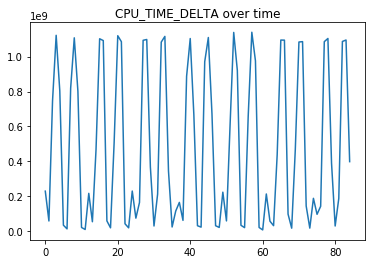

---------------------------------------------------------------


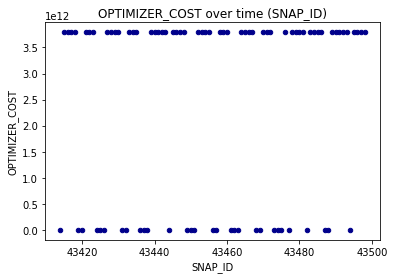

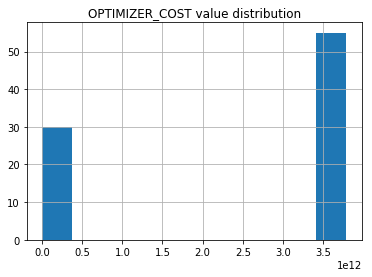

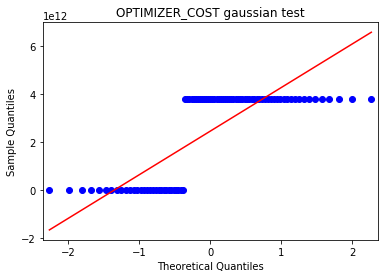

Statistics=0.604, p=0.000
Sample does not look Gaussian (reject H0)


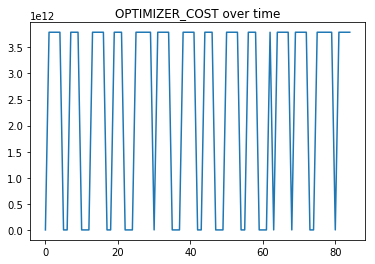

---------------------------------------------------------------


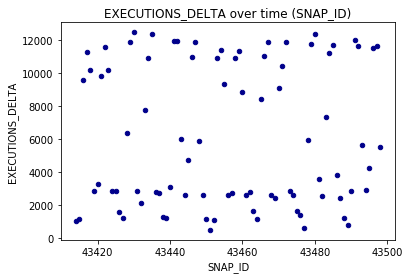

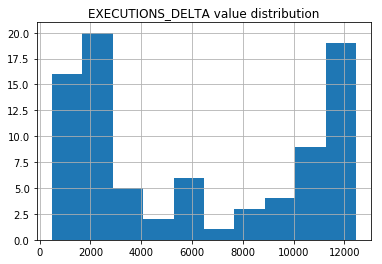

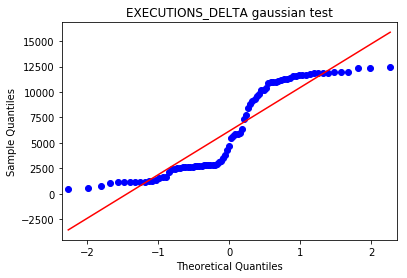

Statistics=0.843, p=0.000
Sample does not look Gaussian (reject H0)


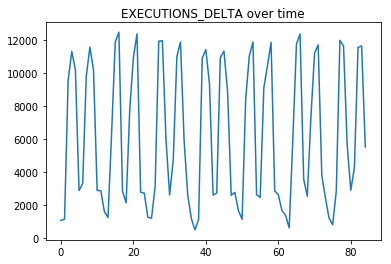

---------------------------------------------------------------


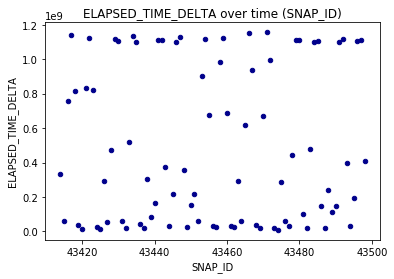

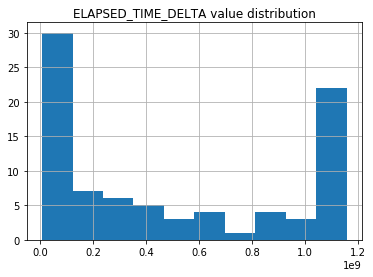

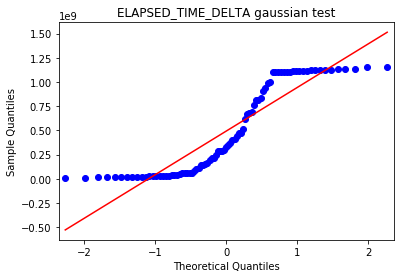

Statistics=0.816, p=0.000
Sample does not look Gaussian (reject H0)


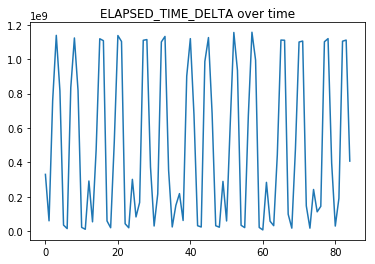

---------------------------------------------------------------


In [10]:
def shapiro_wilk(data):
    # normality test
    stat, p = sc.stats.shapiro(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

for label in y_label:
    
    df.plot.scatter(x='SNAP_ID',
                    y=label,
                    c='DarkBlue')
    plt.title(label + " over time (SNAP_ID)")
    plt.show()
    
    df[label].hist(bins=10)
    plt.title(label + ' value distribution')
    plt.show()
    
    qqplot(df[label], line='s')
    plt.title(label + ' gaussian test')
    plt.show()
    
    shapiro_wilk(data=df[label])
    
    df[label].plot.line()
    plt.title(label + ' over time')
    plt.show()
    print('---------------------------------------------------------------')

### Outlier Detection - Standard Deviation Method

Detection and transformation of outliers, categorized as more than 3 standard deviations away.

If we know that the distribution of values in the sample is Gaussian or Gaussian-like, we can use the standard deviation of the sample as a cut-off for identifying outliers.

The Gaussian distribution has the property that the standard deviation from the mean can be used to reliably summarize the percentage of values in the sample.

For example, within one standard deviation of the mean will cover 68% of the data.

So, if the mean is 50 and the standard deviation is 5, as in the test dataset above, then all data in the sample between 45 and 55 will account for about 68% of the data sample. We can cover more of the data sample if we expand the range as follows:

* 1 Standard Deviation from the Mean: 68%
* 2 Standard Deviations from the Mean: 95%
* 3 Standard Deviations from the Mean: 99.7%

A value that falls outside of 3 standard deviations is part of the distribution, but it is an unlikely or rare event at approximately 1 in 370 samples.

Three standard deviations from the mean is a common cut-off in practice for identifying outliers in a Gaussian or Gaussian-like distribution. For smaller samples of data, perhaps a value of 2 standard deviations (95%) can be used, and for larger samples, perhaps a value of 4 standard deviations (99.9%) can be used.

More infor here: https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/

In [11]:
def get_outliers_std(df=None, headers=None):
    """
    Detect and return which rows are considered outliers within the dataset, determined by :quartile_limit (99%)
    """
    outlier_rows = [] # This list of lists consists of elements of the following notation [column,rowid]
    for header in headers:
        outlier_count = 0
        try:
            # calculate summary statistics
            data_mean, data_std = df[header].mean(), df[header].std()
            # identify outliers
            cut_off = data_std * 3
            lower, upper = data_mean - cut_off, data_mean + cut_off
            
            series_row = (df[df[header] > upper].index)
            outlier_count += len(list(np.array(series_row)))
            for id in list(np.array(series_row)):
                outlier_rows.append([header,id])
            
            series_row = (df[df[header] < lower].index)
            outlier_count += len(list(np.array(series_row)))
            for id in list(np.array(series_row)):
                outlier_rows.append([header,id])
            print(header + ' - [' + str(outlier_count) + '] outliers')
        except Exception as e:
            print(str(e))
    
    unique_outlier_rows = []
    for col, rowid in outlier_rows:
        unique_outlier_rows.append([col,rowid])
    return unique_outlier_rows

#Printing outliers to screen
outliers = get_outliers_std(df=df,
                            headers=y_label)
print('Total Outliers: [' + str(len(outliers)) + ']\n')
for label in y_label:
    min_val = df[label].min()
    max_val = df[label].max()
    mean_val = df[label].mean()
    std_val = df[label].std()
    print('Label[' + label + '] - Min[' + str(min_val) + '] - Max[' + str(max_val) + '] - Mean[' + str(mean_val) + '] - Std[' + str(std_val) + ']')
print('\n---------------------------------------------\n')
for i in range(len(outliers)):
    print('Header [' + str(outliers[i][0]) + '] - Location [' + str(outliers[i][1]) + '] - Value [' + str(df.iloc[outliers[i][1]][outliers[i][0]]) + ']') 

CPU_TIME_DELTA - [0] outliers
OPTIMIZER_COST - [0] outliers
EXECUTIONS_DELTA - [0] outliers
ELAPSED_TIME_DELTA - [0] outliers
Total Outliers: [0]

Label[CPU_TIME_DELTA] - Min[7474309] - Max[1139725457] - Mean[479106790.7411765] - Std[449220876.70265025]
Label[OPTIMIZER_COST] - Min[4670.0] - Max[3790249688682.0] - Mean[2452514342438.294] - Std[1822051467998.121]
Label[EXECUTIONS_DELTA] - Min[479.0] - Max[12468.0] - Mean[6165.035294117647] - Std[4302.233687414067]
Label[ELAPSED_TIME_DELTA] - Min[7719231] - Max[1156984226] - Mean[493104470.0] - Std[452641315.08551955]

---------------------------------------------



### Outlier Detection - Interquartile Range Method

https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/

Not all data is normal or normal enough to treat it as being drawn from a Gaussian distribution.

A good statistic for summarizing a non-Gaussian distribution sample of data is the Interquartile Range, or IQR for short.

The IQR is calculated as the difference between the 75th and the 25th percentiles of the data and defines the box in a box and whisker plot.

Remember that percentiles can be calculated by sorting the observations and selecting values at specific indices. The 50th percentile is the middle value, or the average of the two middle values for an even number of examples. If we had 10,000 samples, then the 50th percentile would be the average of the 5000th and 5001st values.

We refer to the percentiles as quartiles (“quart” meaning 4) because the data is divided into four groups via the 25th, 50th and 75th values.

The IQR defines the middle 50% of the data, or the body of the data.

The IQR can be used to identify outliers by defining limits on the sample values that are a factor k of the IQR below the 25th percentile or above the 75th percentile. The common value for the factor k is the value 1.5. A factor k of 3 or more can be used to identify values that are extreme outliers or “far outs” when described in the context of box and whisker plots.

On a box and whisker plot, these limits are drawn as fences on the whiskers (or the lines) that are drawn from the box. Values that fall outside of these values are drawn as dots.

In [12]:
def get_outliers_quartile(df=None, headers=None):
    """
    Detect and return which rows are considered outliers within the dataset, determined by :quartile_limit (99%)
    """
    outlier_rows = [] # This list of lists consists of elements of the following notation [column,rowid]
    for header in headers:
        outlier_count = 0
        try:
            q25, q75 = np.percentile(df[header], 25), np.percentile(df[header], 75)
            iqr = q75 - q25
            cut_off = iqr * .6 # This values needs to remain as it. It was found to be a good value so as to capture the relavent outlier data
            lower, upper = q25 - cut_off, q75 + cut_off
            
            series_row = (df[df[header] > upper].index)
            outlier_count += len(list(np.array(series_row)))
            for id in list(np.array(series_row)):
                outlier_rows.append([header,id])
            
            series_row = (df[df[header] < lower].index)
            outlier_count += len(list(np.array(series_row)))
            for id in list(np.array(series_row)):
                outlier_rows.append([header,id])
            print(header + ' - [' + str(outlier_count) + '] outliers')
        except Exception as e:
            print(str(e))
    
    unique_outlier_rows = []
    for col, rowid in outlier_rows:
        unique_outlier_rows.append([col,rowid])
    return unique_outlier_rows

#Printing outliers to screen
outliers = get_outliers_quartile(df=df,
                                 headers=y_label)
print('Total Outliers: [' + str(len(outliers)) + ']\n')
for label in y_label:
    min_val = df[label].min()
    max_val = df[label].max()
    mean_val = df[label].mean()
    std_val = df[label].std()
    print('Label[' + label + '] - Min[' + str(min_val) + '] - Max[' + str(max_val) + '] - Mean[' + str(mean_val) + '] - Std[' + str(std_val) + ']')
print('\n---------------------------------------------\n')
for i in range(len(outliers)):
    print('Header [' + str(outliers[i][0]) + '] - Location [' + str(outliers[i][1]) + '] - Value [' + str(df.iloc[outliers[i][1]][outliers[i][0]]) + ']') 

CPU_TIME_DELTA - [0] outliers
OPTIMIZER_COST - [0] outliers
EXECUTIONS_DELTA - [0] outliers
ELAPSED_TIME_DELTA - [0] outliers
Total Outliers: [0]

Label[CPU_TIME_DELTA] - Min[7474309] - Max[1139725457] - Mean[479106790.7411765] - Std[449220876.70265025]
Label[OPTIMIZER_COST] - Min[4670.0] - Max[3790249688682.0] - Mean[2452514342438.294] - Std[1822051467998.121]
Label[EXECUTIONS_DELTA] - Min[479.0] - Max[12468.0] - Mean[6165.035294117647] - Std[4302.233687414067]
Label[ELAPSED_TIME_DELTA] - Min[7719231] - Max[1156984226] - Mean[493104470.0] - Std[452641315.08551955]

---------------------------------------------



In [13]:
def edit_outliers(df=None, headers=None):
    """
    This method uses the interquartile method to edit all outliers to std.
    """
    outliers = get_outliers_quartile(df=df,
                                     headers=y_label)
    for label in y_label:
        min_val = df[label].min()
        max_val = df[label].max()
        mean_val = df[label].mean()
        std_val = df[label].std()
        
        for i in range(len(outliers)):
            if label == outliers[i][0]:
                df[label].iloc[outliers[i][1]] = mean_val + std_val
                # print('Header [' + str(outliers[i][0]) + '] - Location [' + str(outliers[i][1]) + '] - Value [' + str(df.iloc[outliers[i][1]][outliers[i][0]]) + ']')
    return df

print("DF with outliers: " + str(df.shape))
df = edit_outliers(df=df,
                   headers=y_label)
print("DF with edited outliers: " + str(df.shape))

DF with outliers: (85, 486)
CPU_TIME_DELTA - [0] outliers
OPTIMIZER_COST - [0] outliers
EXECUTIONS_DELTA - [0] outliers
ELAPSED_TIME_DELTA - [0] outliers
DF with edited outliers: (85, 486)


### Normalization

Relavent Sources:

* http://jmlr.csail.mit.edu/papers/volume3/guyon03a/guyon03a.pdf
* https://machinelearningmastery.com/rescaling-data-for-machine-learning-in-python-with-scikit-learn/

https://machinelearningmastery.com/normalize-standardize-time-series-data-python/ recommends a normalization preprocessing technique for data distribution that can closely approximate minimum and maximum observable values per column:

<i>"Normalization requires that you know or are able to accurately estimate the minimum and maximum observable values. You may be able to estimate these values from your available data. If your time series is trending up or down, estimating these expected values may be difficult and normalization may not be the best method to use on your problem."</i>

Normalization formula is stated as follows: $$y=(x-min)/(max-min)$$

### Standardization

https://machinelearningmastery.com/normalize-standardize-time-series-data-python/ recommends a standardization preprocessing technique for data distributions that observe a Gaussian spread, with a mean of 0 and a standard deviation of 1 (approximately close to these values):

<i>"Standardization assumes that your observations fit a Gaussian distribution (bell curve) with a well behaved mean and standard deviation. You can still standardize your time series data if this expectation is not met, but you may not get reliable results."</i>

Standardization formula is stated as follows: $$y=(x-mean)/StandardDeviation$$
Mean defined as: $$mean=sum(x)/count(x)$$
Standard Deviation defined as: $$StandardDeviation=sqrt(sum((x-mean)^2)/count(x))$$

In [14]:
class Normalizer:

    @staticmethod
    def robust_scaler(dataframe):
        """
        Normalize df using interquartile ranges as min-max, this way outliers do not play a heavy emphasis on the
        normalization of values.
        :param dataframe: (Pandas) Pandas data matrix
        :return: (Pandas) Normalized data matrix
        """
        headers = dataframe.columns
        X = preprocessing.robust_scale(dataframe.values)
        return pd.DataFrame(X, columns=headers)

    @staticmethod
    def minmax_scaler(dataframe):
        """
        Normalize df using min-max ranges for normalization method
        :param dataframe: (Pandas) Pandas data matrix
        :return: (Pandas) Normalized data matrix
        """
        headers = dataframe.columns
        X = preprocessing.minmax_scale(dataframe.values)
        return pd.DataFrame(X, columns=headers)

    @staticmethod
    def normalize(dataframe):
        """
        The normalizer scales each value by dividing each value by its magnitude in n-dimensional space for n number of features.
        :param dataframe: (Pandas) Pandas data matrix
        :return: (Pandas) Normalized data matrix
        """
        headers = dataframe.columns
        X = preprocessing.normalize(dataframe.values)
        return pd.DataFrame(X, columns=headers)

print('------------------BEFORE------------------')
print('------------------DF------------------')
print(df.shape)
print('\n')

# ROBUST SCALER
# df = Normalizer.robust_scaler(dataframe=df)

# MINMAX SCALER
df = Normalizer.minmax_scaler(dataframe=df)

# NORMALIZER
#df = Normalizer.normalize(dataframe=df)

print('\n\n------------------AFTER------------------')
print('------------------df------------------')
print(df.shape)
print('\n\n')
print('\n\ndf')
print(df.head())

------------------BEFORE------------------
------------------DF------------------
(85, 486)




------------------AFTER------------------
------------------df------------------
(85, 486)





df
    SNAP_ID  OPTIMIZER_COST  SHARABLE_MEM  FETCHES_TOTAL  FETCHES_DELTA  \
0  0.000000    4.461685e-08      0.016052       0.000000       0.119614   
1  0.011905    9.999997e-01      0.058314       0.881126       0.036219   
2  0.023810    1.000000e+00      0.295970       0.858881       0.785527   
3  0.035714    1.000000e+00      0.310004       0.867184       0.894997   
4  0.047619    1.000000e+00      0.474497       0.877906       0.809251   

   END_OF_FETCH_COUNT_TOTAL  END_OF_FETCH_COUNT_DELTA  SORTS_TOTAL  \
0                  0.010867                  0.051562     0.047593   
1                  0.958098                  0.064167     0.951472   
2                  0.859633                  0.756875     0.969801   
3                  0.887522                  0.901146     0.975974   
4   

### Rearranging Labels

Removes the label column, and adds it at the beginning of the matrix for later usage

In [15]:
y_label.append('SNAP_ID')
y_df = df[y_label]
del y_label[-1]
df.drop(columns=y_label, inplace=True)
print("Label " + str(y_label) + " shape: " + str(y_df.shape))
print("Feature matrix shape: " + str(df.shape))

# Merging labels and features in respective order
df = pd.merge(y_df,df,on='SNAP_ID',sort=False,left_on=None, right_on=None)
print('Merged Labels + Vectors: ' + str(df.shape))
print(df.head())

Label ['CPU_TIME_DELTA', 'OPTIMIZER_COST', 'EXECUTIONS_DELTA', 'ELAPSED_TIME_DELTA'] shape: (85, 5)
Feature matrix shape: (85, 482)
Merged Labels + Vectors: (85, 486)
   CPU_TIME_DELTA  OPTIMIZER_COST  EXECUTIONS_DELTA  ELAPSED_TIME_DELTA  \
0        0.196050    4.461685e-08          0.047627            0.280894   
1        0.045211    9.999997e-01          0.054717            0.046058   
2        0.653106    1.000000e+00          0.758529            0.653825   
3        0.984491    1.000000e+00          0.902411            0.984271   
4        0.703771    1.000000e+00          0.809909            0.704041   

    SNAP_ID  SHARABLE_MEM  FETCHES_TOTAL  FETCHES_DELTA  \
0  0.000000      0.016052       0.000000       0.119614   
1  0.011905      0.058314       0.881126       0.036219   
2  0.023810      0.295970       0.858881       0.785527   
3  0.035714      0.310004       0.867184       0.894997   
4  0.047619      0.474497       0.877906       0.809251   

   END_OF_FETCH_COUNT_TOTAL

### Lag and Autocorrelation Analysis
This section checks for potential autocorrelation within the presented time series. Three seperate plots are layed out as follows:

* Plot 1 - Lag plot denoting correlation between time lag 0 and time lag 1.
* Plot 2 - Auto correlation plot denoting time series correlation over a number of lag values
* Plot 3 - Auto correlation plot denoting time series correlation up till lag value 100. This achieves a much more closer look towards the first 100 lag correlations for the time series, achieving a more detailed plot.
Relavent sources:

* http://pandasplotting.blogspot.com/2012/06/autocorrelation-plot.html
* https://pandas.pydata.org/pandas-docs/stable/visualization.html
* https://machinelearningmastery.com/time-series-data-visualization-with-python/

In [ ]:
def qualify_lag(data, labels):
    for label in labels:
        print('Label - [' + label + ']')
        plot_acf(data[label])
        plt.rcParams['figure.figsize'] = [20, 15]
        plt.title('Autocorrelation Plot - label [' + label + ']')
        plt.show()
        plot_acf(data[label], lags=100)
        plt.rcParams['figure.figsize'] = [20, 15]
        plt.title('Autocorrelation Plot - label [' + label + '] (lag 0 - 100)')
        plt.show()
        lag_plot(data[label], lag=13) # Lag 13 is hardcoded, and derived from the above auto correlation plot.
        plt.rcParams['figure.figsize'] = [20, 15]
        plt.title('Lag Plot (Lag=13) - label [' + label + ']')
        plt.show()

qualify_lag(data=df,
            labels=y_label)

### Time Series Shifting

Shifting the datasets N lag minutes, in order to transform the problem into a supervised dataset. Each Lag Shift equates to 60 seconds (due to the way design of the data capturing tool). For each denoted lag amount, the same number of feature vectors will be stripped away at the beginning.

Features and Labels are separated into seperate dataframes at this point.

https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [16]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = data
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    if n_in != 0:
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    n_out += 1
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def remove_n_time_steps(data, n=1):
    if n == 0:
        return data
    df = data
    headers = df.columns
    dropped_headers = []
    
    for i in range(1,n+1):
        for header in headers:
            if "(t+"+str(i)+")" in header:
                dropped_headers.append(str(header))
    
    return df.drop(dropped_headers, axis=1) 

# Frame as supervised learning set
shifted_df = series_to_supervised(df, lag, lag)

# Seperate labels from features
y_row = []
for i in range(lag+1,(lag*2)+2):
    y_df_column_names = shifted_df.columns[len(df.columns)*i:len(df.columns)*i + len(y_label)]
    y_row.append(y_df_column_names)
    print(y_df_column_names)
    print(type(y_df_column_names))
y_df_column_names = []   
for row in y_row:
    for val in row:
        y_df_column_names.append(val)

# y_df_column_names = shifted_df.columns[len(df.columns)*lag:len(df.columns)*lag + len(y_label)]
y_df = shifted_df[y_df_column_names]
X_df = shifted_df.drop(columns=y_df_column_names)
print('\n-------------\nFeatures')
print(X_df.columns)
print(X_df.shape)
print('\n-------------\nLabels')
print(y_df.columns)
print(y_df.shape)

# Delete middle timesteps
X_df = remove_n_time_steps(data=X_df, n=lag)
print('\n-------------\nFeatures After Time Shift')
print(X_df.columns)
print(X_df.shape)
# y_df = remove_n_time_steps(data=y_df, n=lag)
print('\n-------------\nLabels After Time Shift')
print(y_df.columns)
print(y_df.shape)

Index(['var1(t+1)', 'var2(t+1)', 'var3(t+1)', 'var4(t+1)'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
Index(['var1(t+2)', 'var2(t+2)', 'var3(t+2)', 'var4(t+2)'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
Index([], dtype='object')
<class 'pandas.core.indexes.base.Index'>

-------------
Features
Index(['var1(t-2)', 'var2(t-2)', 'var3(t-2)', 'var4(t-2)', 'var5(t-2)',
       'var6(t-2)', 'var7(t-2)', 'var8(t-2)', 'var9(t-2)', 'var10(t-2)',
       ...
       'var477(t+2)', 'var478(t+2)', 'var479(t+2)', 'var480(t+2)',
       'var481(t+2)', 'var482(t+2)', 'var483(t+2)', 'var484(t+2)',
       'var485(t+2)', 'var486(t+2)'],
      dtype='object', length=2422)
(81, 2422)

-------------
Labels
Index(['var1(t+1)', 'var2(t+1)', 'var3(t+1)', 'var4(t+1)', 'var1(t+2)',
       'var2(t+2)', 'var3(t+2)', 'var4(t+2)'],
      dtype='object')
(81, 8)

-------------
Features After Time Shift
Index(['var1(t-2)', 'var2(t-2)', 'var3(t-2)', 'var4(t-2)', 'var5(t-2)',
       'var6(t-2)

### Test Split Train / Validation / Test

Split main feature/label matrix/vector into 2 subsets. 
* First subset will be used for training the model
* The other subset is split into two further subsets:
    - Model Validation
    - Model Testing
    
The training test itself is further reshaped, so as to satisfy the format required by LSTMS

X_train shape [(64, 1458)] Type - <class 'numpy.ndarray'>
y_train shape [(64, 8)] Type - <class 'numpy.ndarray'>
X_validate shape [(8, 1458)] Type - <class 'numpy.ndarray'>
y_validate shape [(8, 8)] Type - <class 'numpy.ndarray'>
X_test shape [(9, 1458)] Type - <class 'numpy.ndarray'>
y_test shape [(9, 8)] Type - <class 'numpy.ndarray'>


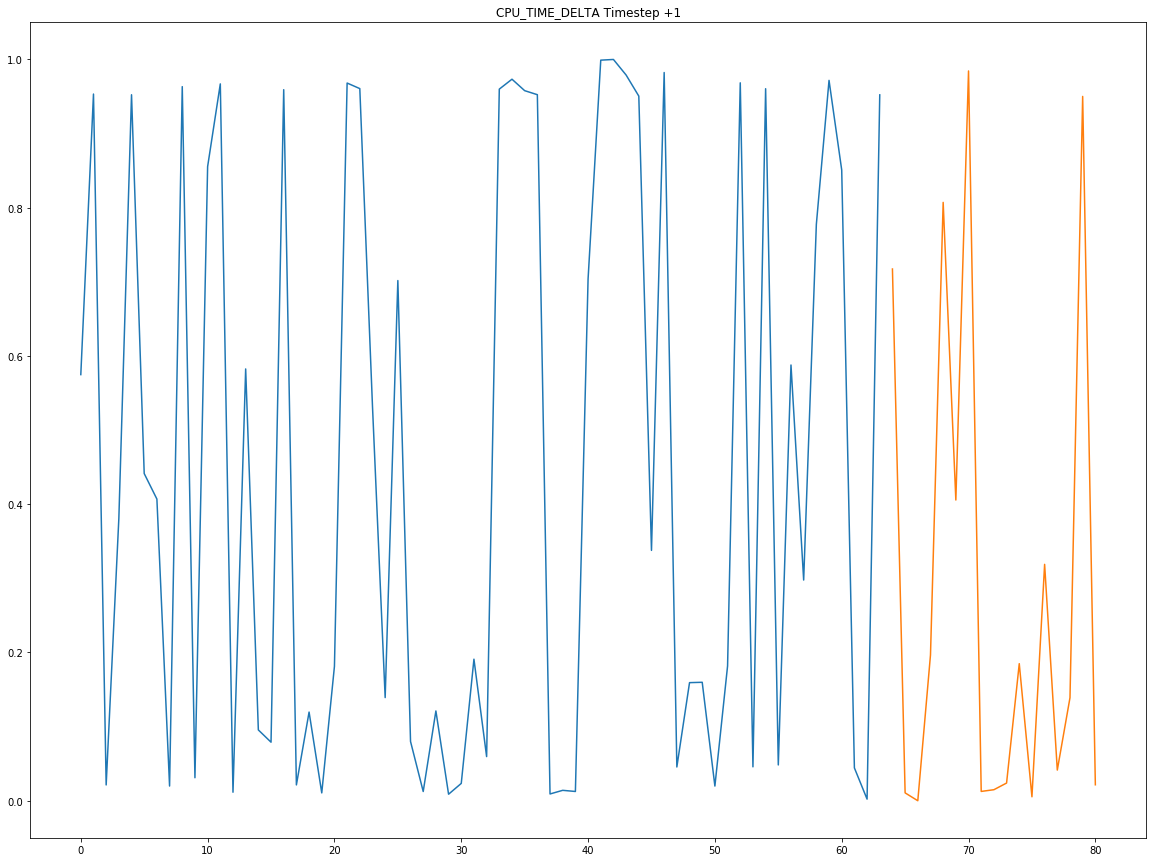

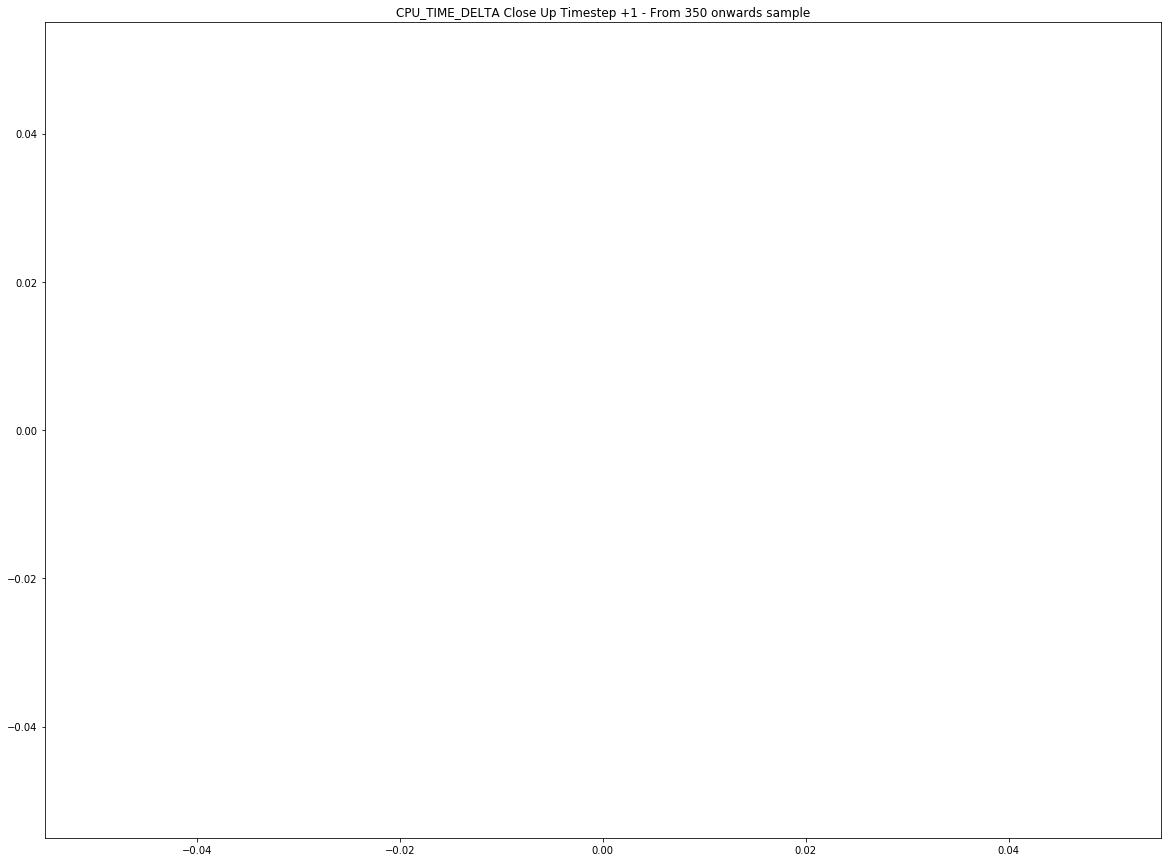

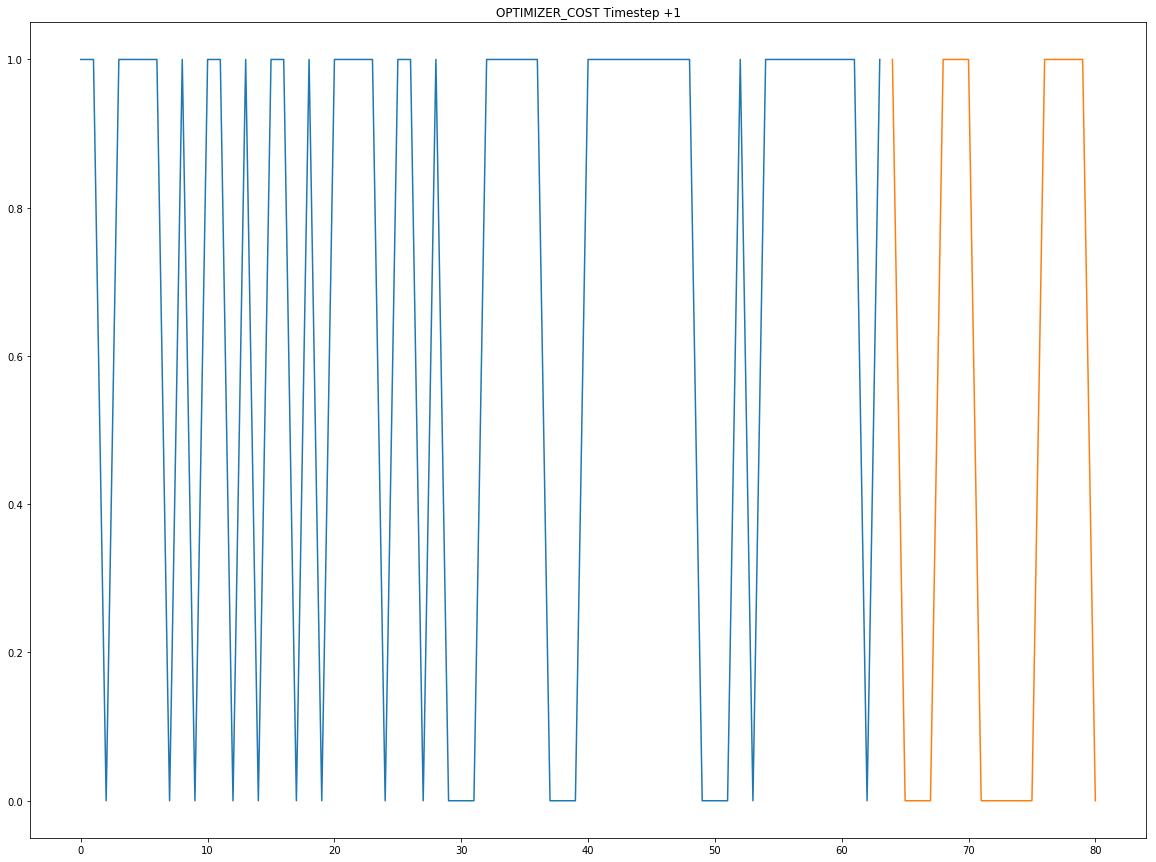

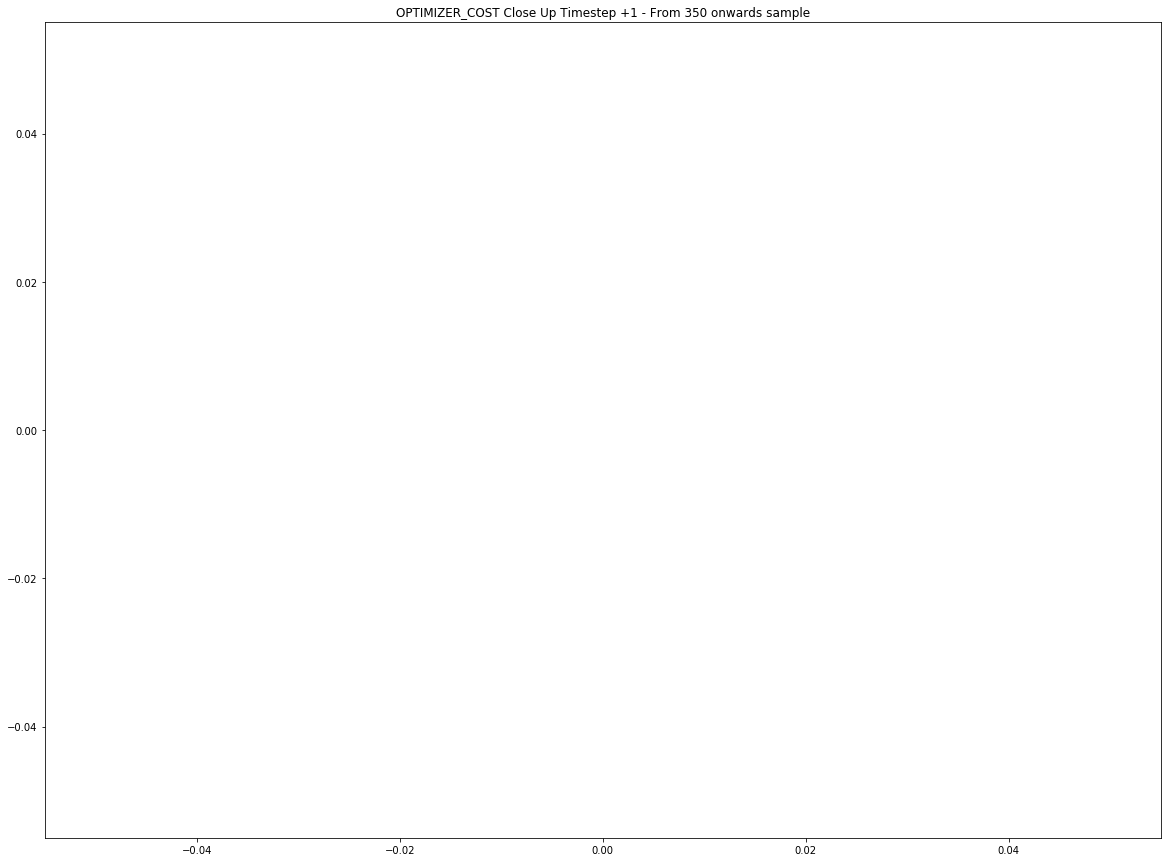

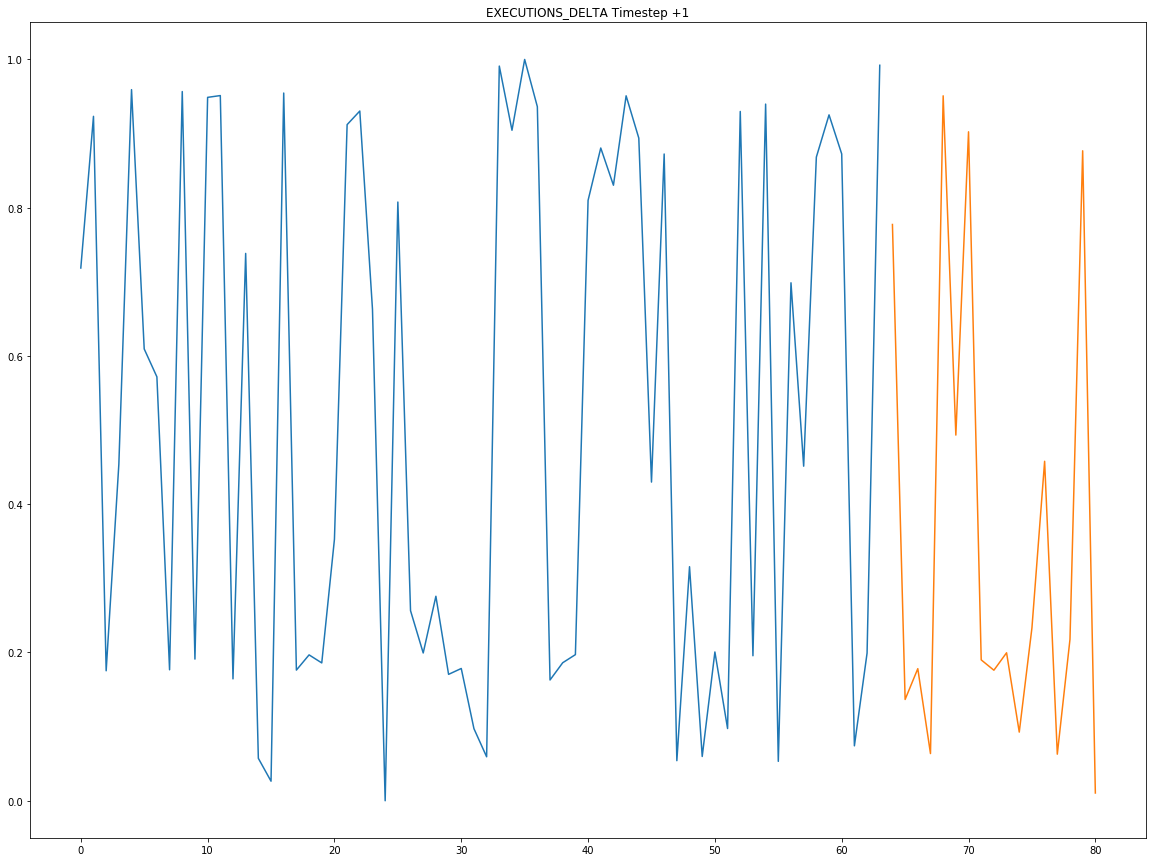

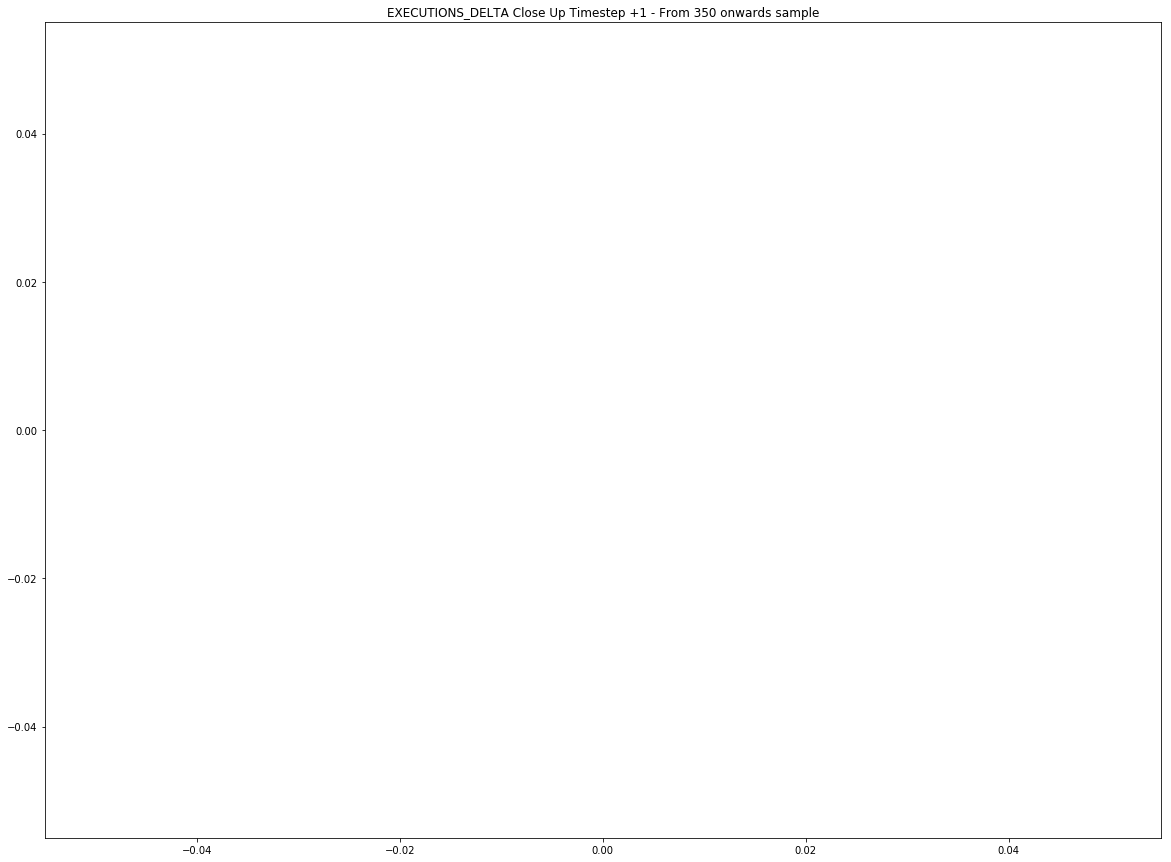

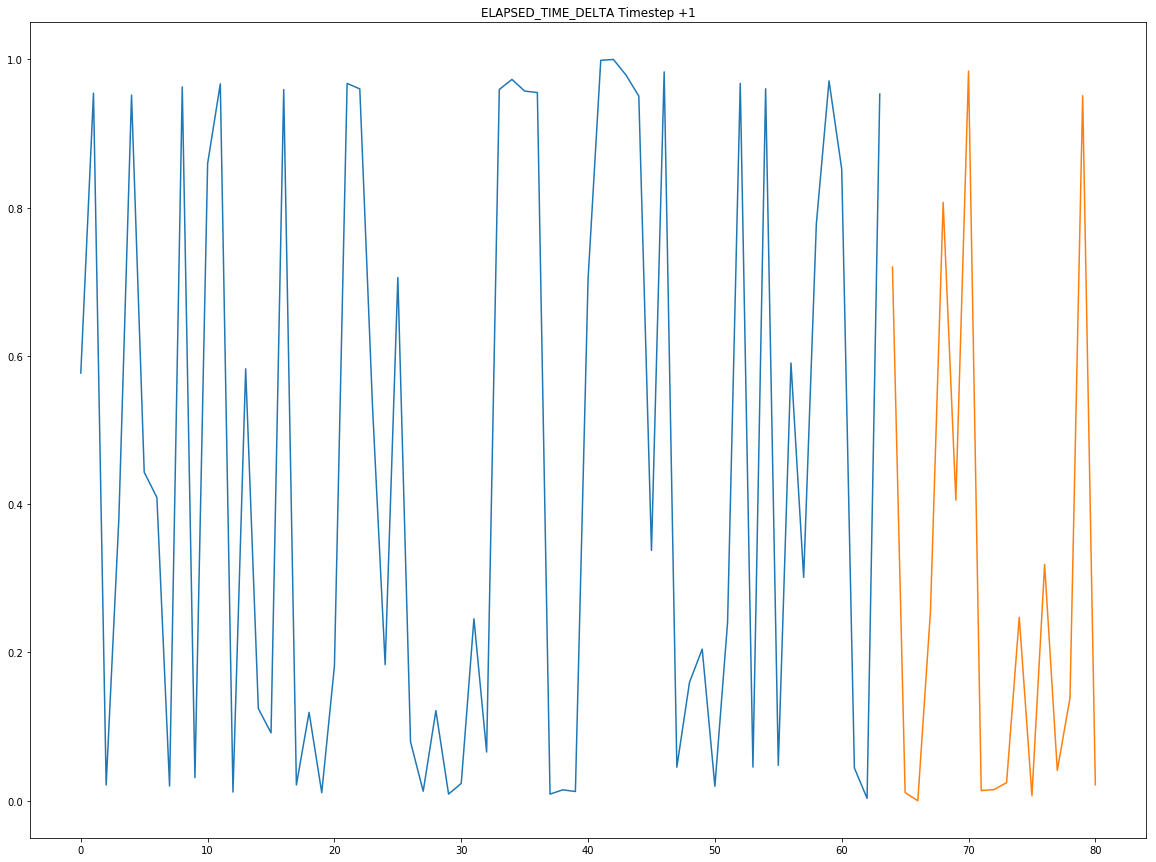

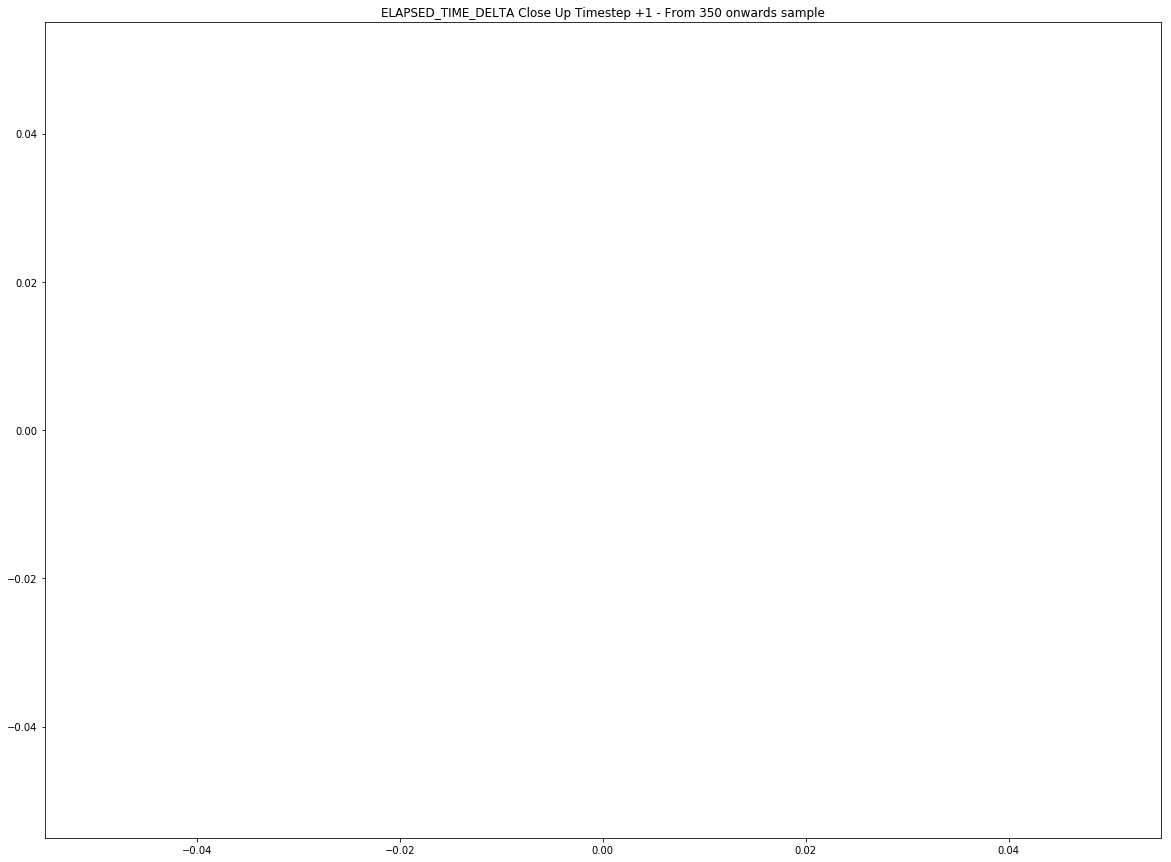

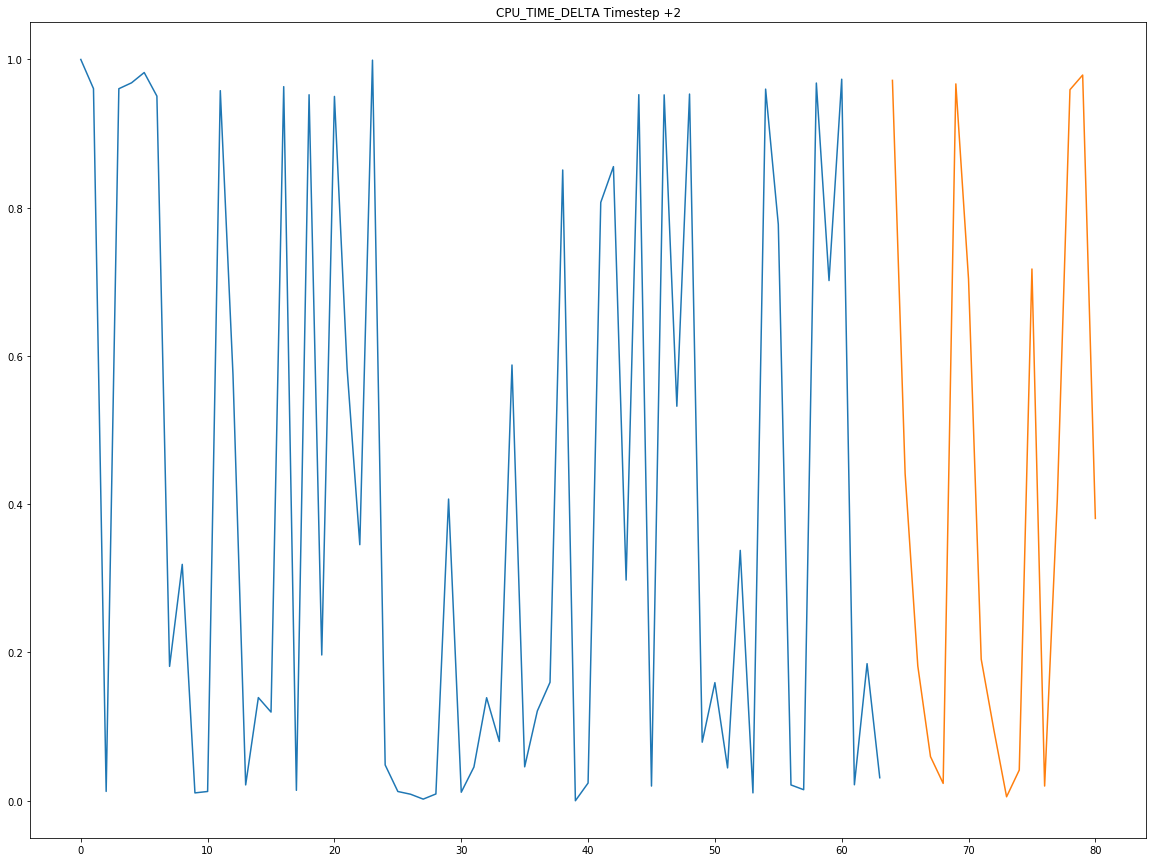

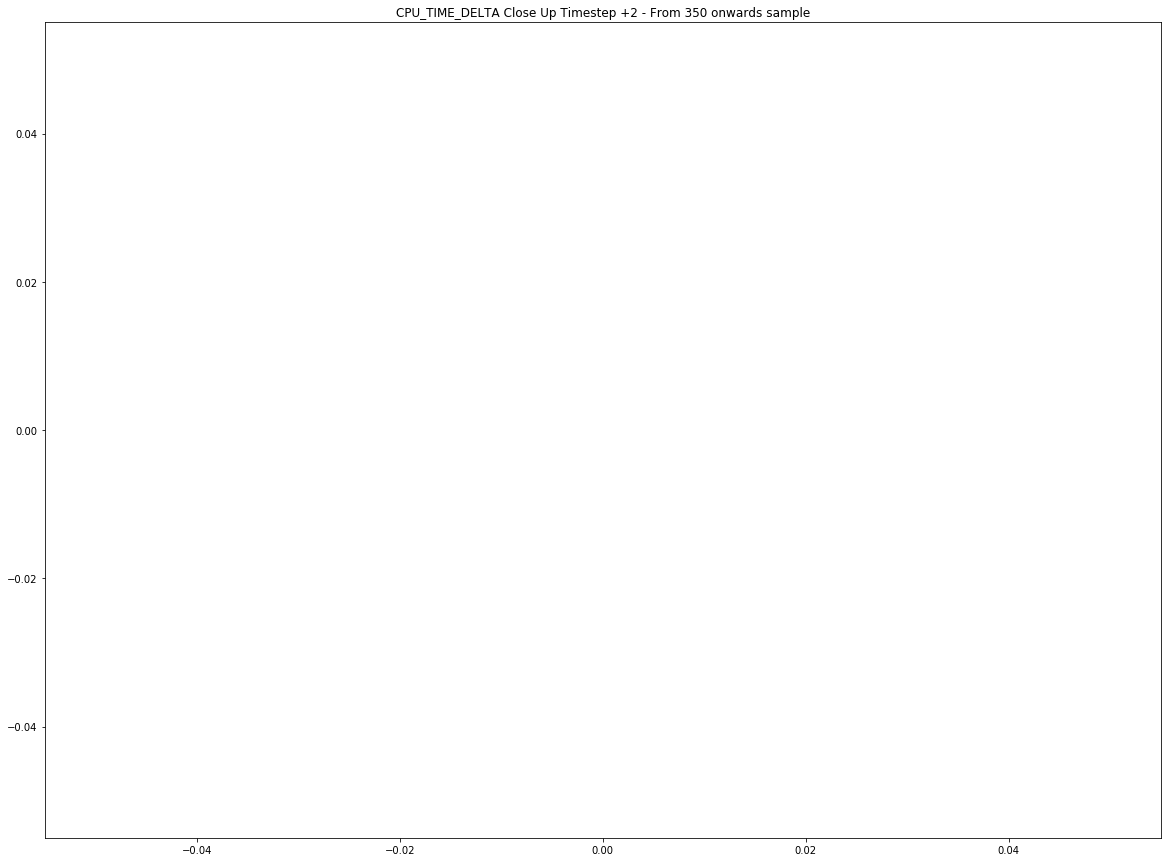

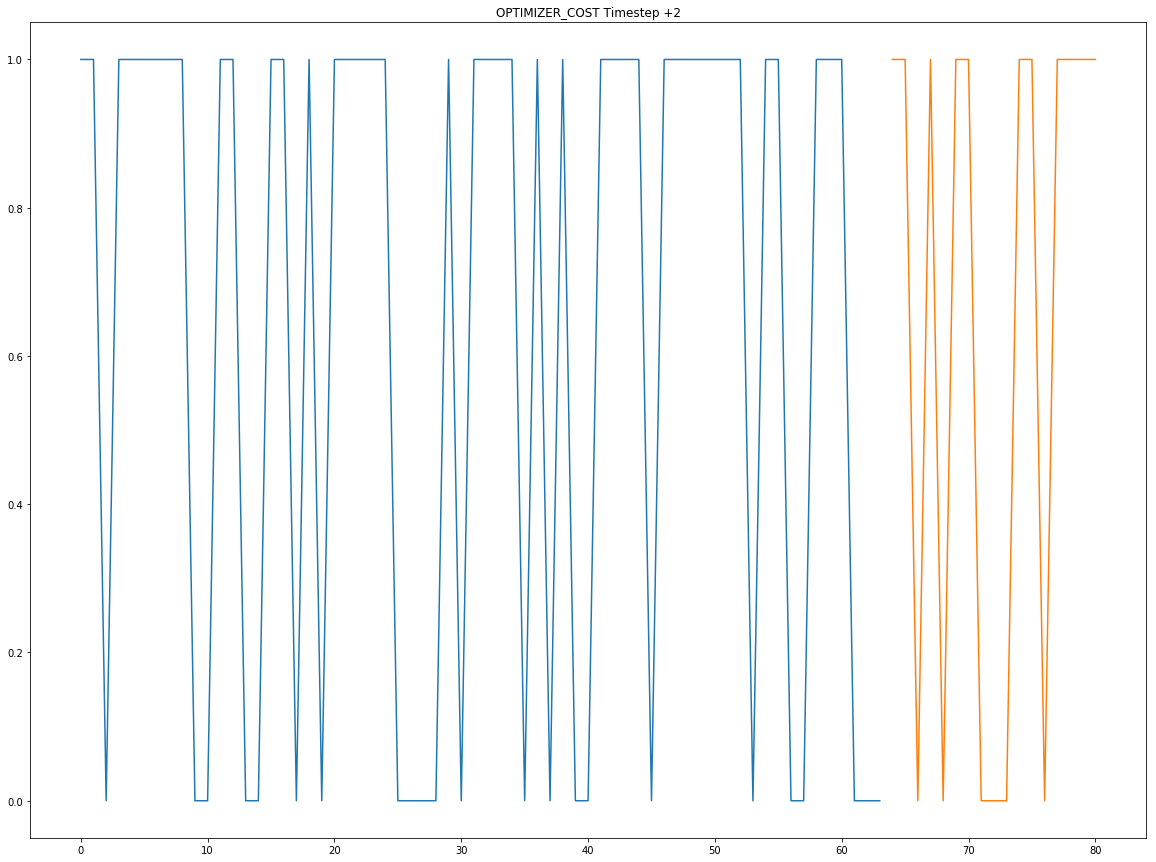

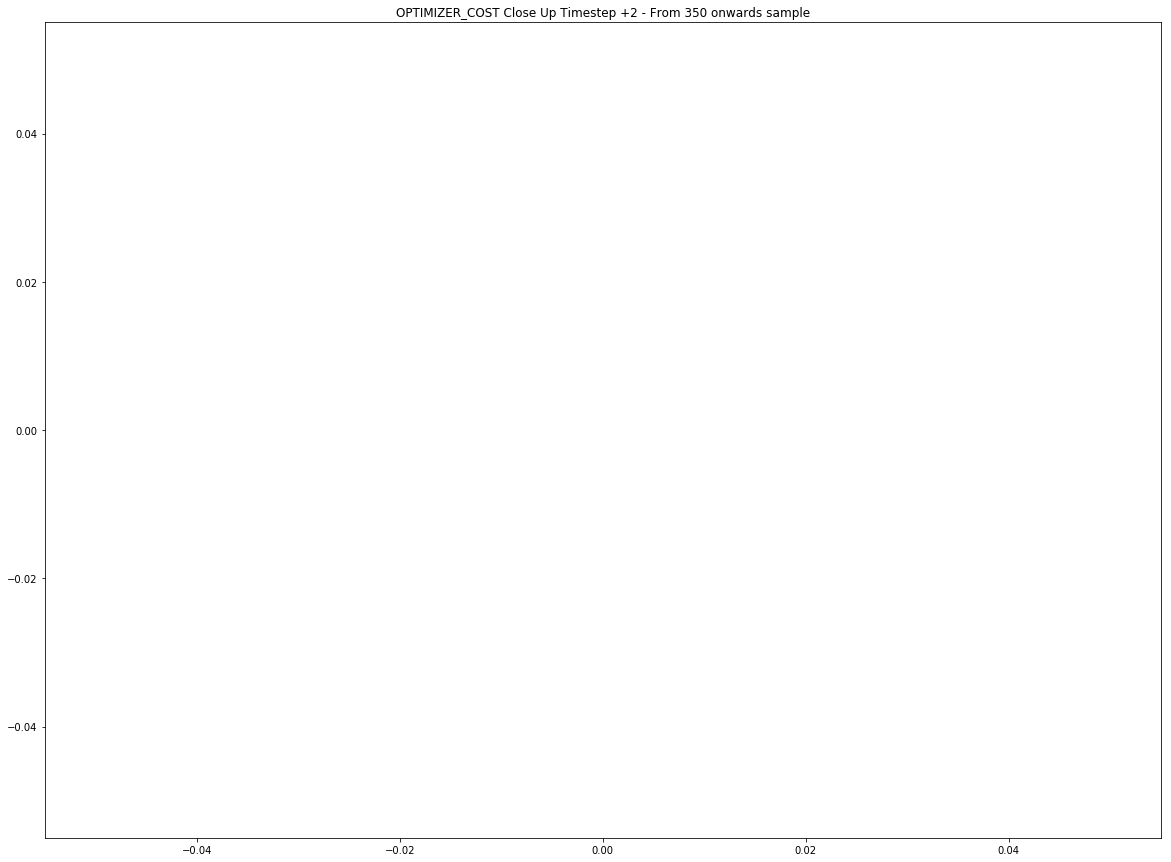

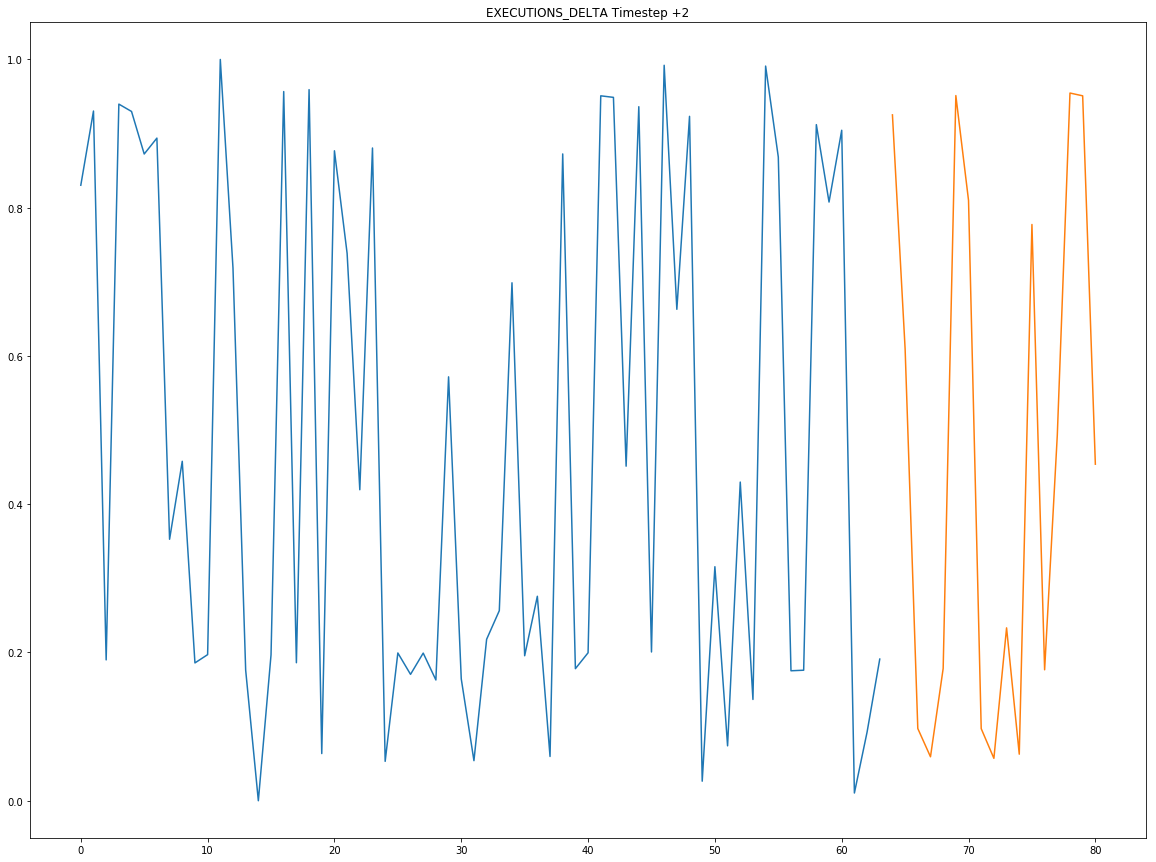

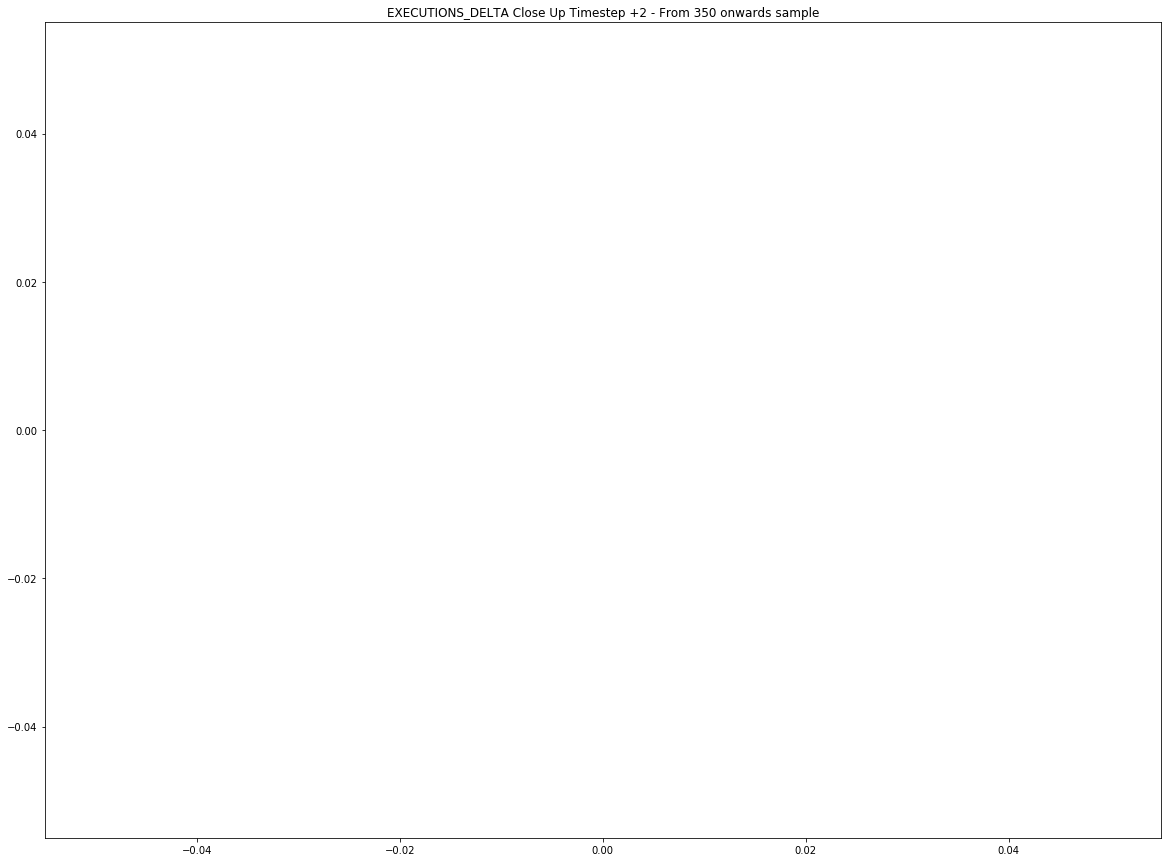

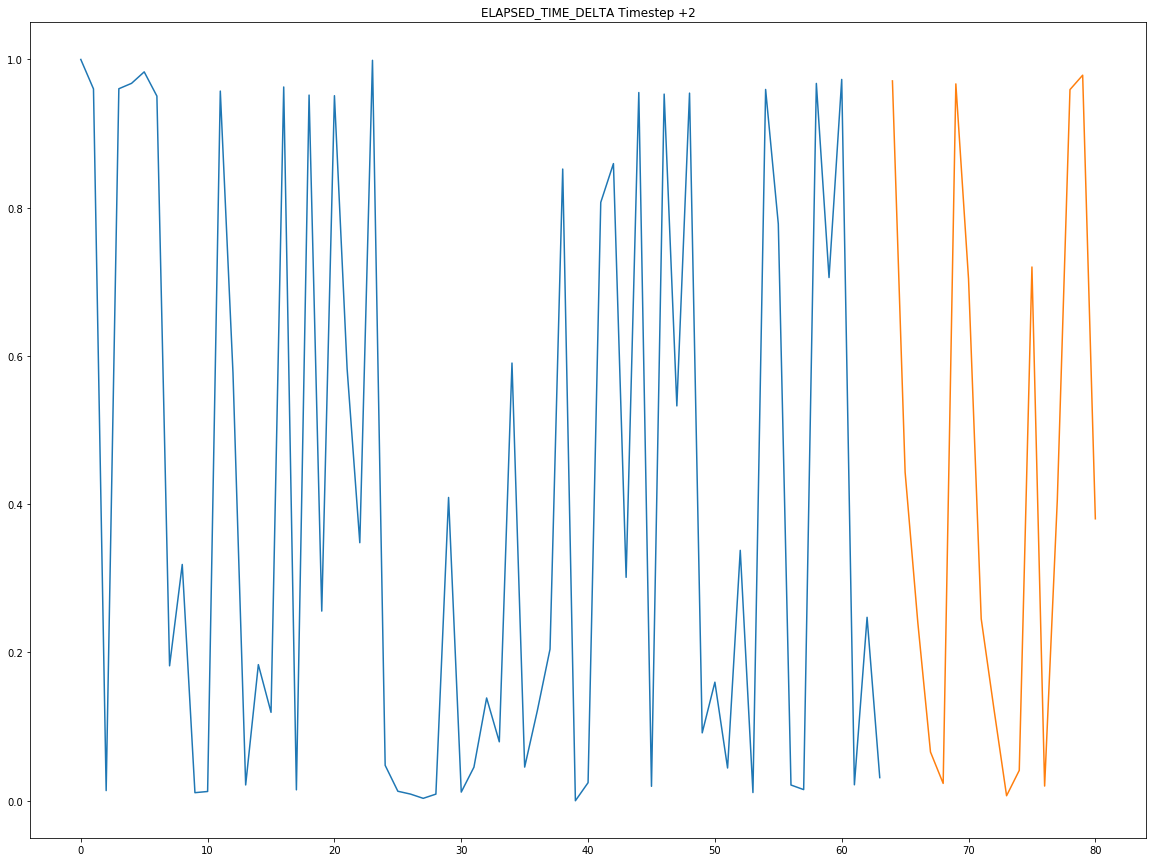

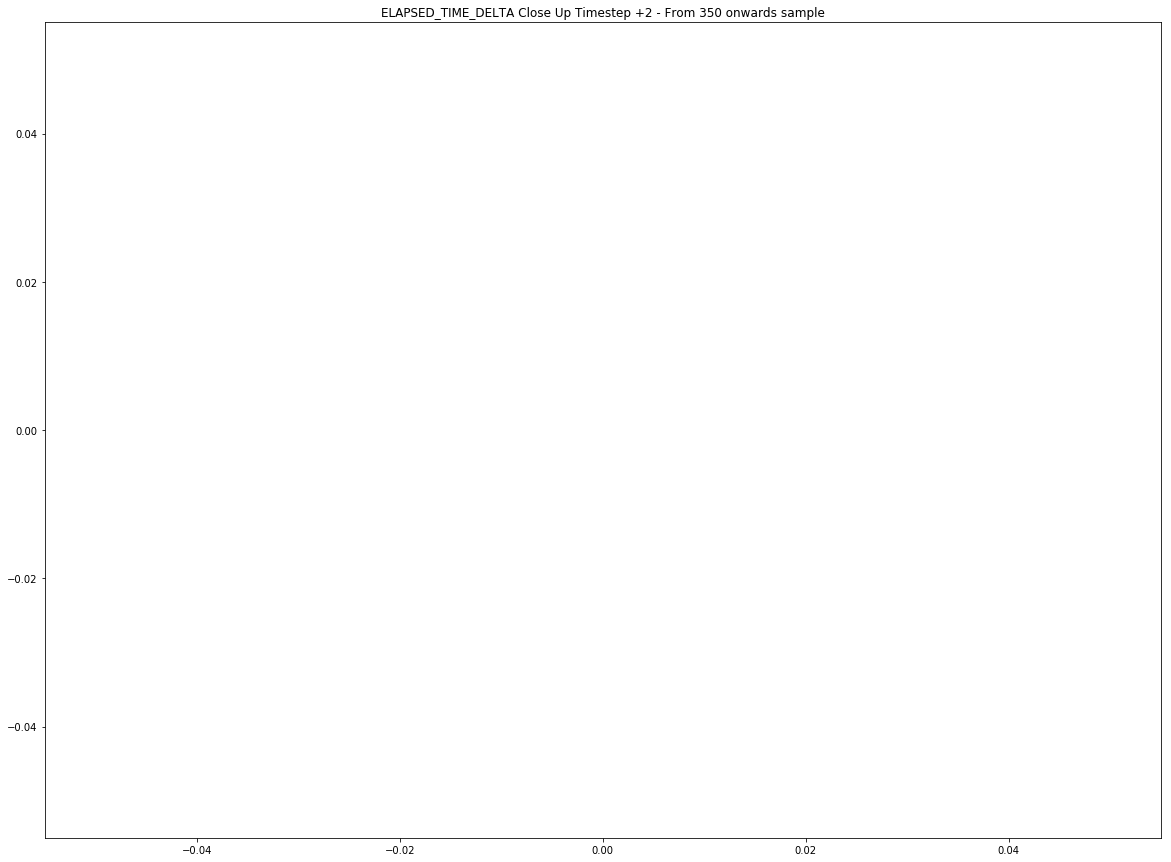

In [17]:
X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))

X_validate, X_test, y_validate, y_test = train_test_split(X_validate, y_validate, test_size=.5)
X_validate = X_validate.values
X_test = X_test.values
y_validate = y_validate.values
y_test = y_test.values
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))
print("X_test shape [" + str(X_test.shape) + "] Type - " + str(type(X_test)))
print("y_test shape [" + str(y_test.shape) + "] Type - " + str(type(y_test)))

# Plotting label over time for train, test
# print(y_train)
# print(y_train[:,0])
for i in range(0, len(y_validate[0])):
    #
    # Whole Sample
    plt.rcParams['figure.figsize'] = [20, 15]
    plt.plot(y_train[:,i])
    validate_and_test = list(y_validate[:,i]) + list(y_test[:,i])
    plt.plot([None for j in y_train[:,i]] + [x for x in validate_and_test])
    plt.title(y_label[i%len(y_label)] + " Timestep +" + str(math.ceil((i+1)/len(y_label))))
    plt.show()
    #
    # Sub-Sample (100 range)
    plt.rcParams['figure.figsize'] = [20, 15]
    plt.plot([j for j in y_train[sub_sample_start:sub_sample_start+100,i]])
    plt.title(y_label[i%len(y_label)] + " Close Up Timestep +" + str(math.ceil((i+1)/len(y_label))) +" - From " + str(sub_sample_start) + " onwards sample")
    plt.show()

### Feature Selection

Implements a recursive solution, where in features are eliminated based on an ensemble evaluator.

In [18]:
class FeatureEliminator:
    """
    This class is dedicated to housing logic pertaining to feature selection - retaining only labels which are considered
    important.
    """
    def __init__(self, X_df, y_df):
        """
        Class constructor.
        :param X_df: (Pandas) Pandas feature matrix.
        :param y_df: (Pandas) Pandas label matrix.
        :return: None
        """
        self.__X_df = X_df
        self.__y_df = y_df
    
    def rfe_selector(self, test_split=.4, optimum_feature_count=0, parallel_degree=1, max_depth=None, max_features='sqrt', n_estimators=100):
        """
        Recursive Feature Elimination Function. Isolates and eliminated features one by one, up till the desired amount, starting
        by features which are considered less important.
        :param test_split:            (Float) Denotes training/testing data split.
        :param optimum_feature_count: (Integer) Denotes the best estimated number of features to retain before a performance drop
                                                is estimated.
        :param parallel_degree:       (Integer) Denotes model training parallel degree.
        :param max_depth:             (Integer) Denotes number of leaves to evaluate during decision tree pruning.
        :param max_features:          (Integer) Denotes number of features to consider during random subselection.
        :param n_estimators:          (Integer) Number of estimators (trees) to build for decision making.
        :return: (List) This list is composed of boolean values, which correspond to the input feature column headers. True List 
                        values denote columns which have been retained. False values denote eliminated feature headers.
        :return: (List) This list denotes feature rankings, which correspond to the input feature column headers. Values of '1',
                        denote that features have been retained.
        """
        X_df = self.__X_df.values
        y_df = self.__y_df[self.__y_df.columns[0]].values  # We can only use a single target column since RandomForests do not support multi target labels
        print(X_df.shape)
        print(y_df.shape)
        optimum_feature_count = int(optimum_feature_count)
        
        X_train, X_test, y_train, y_test = train_test_split(X_df, 
                                                            y_df, 
                                                            test_size=test_split)
        model = RandomForestRegressor(n_estimators=int(n_estimators), 
                                      n_jobs=parallel_degree,
                                      max_depth=max_depth,
                                      max_features='sqrt')

        # create the RFE model and select N attributes
        rfe_model = RFE(model, optimum_feature_count, step=1)
        rfe_model = rfe_model.fit(X_train, y_train)

        # summarize the selection of the attributes
        print(rfe_model.support_)
        print(rfe_model.ranking_)

        # evaluate the model on testing set
        pred_y = rfe_model.predict(X_test)
        predictions = [round(value) for value in pred_y]
        r2s = r2_score(y_test, predictions)
        
        return rfe_model.support_, rfe_model.ranking_
    
    def get_selected_features(self, column_mask):
        """
        Retrieves features which have not been eliminated from the RFE function.
        :param column_mask: (List) This list is composed of boolean values, which correspond to the input feature column headers. 
                                   True list values denote columns which have been retained. False values denote eliminated 
                                   feature headers. 
        :return: (Pandas) Pandas data matrix.
        """
        recommended_columns = []
        for i in range(len(self.__X_df.columns)):
            if (column_mask[i]):
                recommended_columns.append(self.__X_df.columns[i])
                
        return self.__X_df[recommended_columns]
    
fe = FeatureEliminator(X_df=X_df,
                       y_df=y_df)
column_mask, column_rankings = fe.rfe_selector(test_split=test_split,
                                               optimum_feature_count=X_df.shape[1]/4,
                                               parallel_degree=parallel_degree,
                                               max_depth=None,
                                               max_features='sqrt',
                                               n_estimators=X_df.shape[1]*2)
print(X_df.columns)
X_df = fe.get_selected_features(column_mask=column_mask)
print(X_df.columns)

(81, 1458)
(81,)


KeyboardInterrupt: 

### Value Decomposition

Principal component analysis: Factor model in which the factors are based on summarizing the total variance. With PCA, unities are used in the diagonal of the correlation matrix computationally implying that all the variance is common or shared.

https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe

In [ ]:
class PrincipalComponentAnalysisClass:
    """
    This class handles logic related to PCA data transformations.
    https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe
    """
    def __init__(self, X_df):
        """
        Cosntructor method.
        :param X_df: (Pandas) Dataframe consisting of input features, which will be subject to PCA.
        :return: None
        """
        self.__X_df = X_df
        
    def get_default_component_variances(self):
        """
        Fitting the PCA algorithm with our Data.
        :return: (Numpy array) Array of feature variances.
        """
        pca = PCA().fit(self.__X_df.values)
        return np.cumsum(pca.explained_variance_ratio_)
        
    def get_default_component_count(self, threshold=.99):
        """
        Retrieves the recommended number of component decomposition, above which very little variance 
        gain is achieved. This treshold will be set at a 0.999 variance threshold.
        :param threshold: (Float) Threshold value between 0 and 1. Stops immediately as soon the number
                                  of required components exceeds the threshold value.
        :return: (Integer) Returns the number of recommended components.
        """
        variance_ratios = self.get_default_component_variances()
        n = 0
        for val in variance_ratios:
            if val < threshold:
                n += 1
        return n
    
    def plot_variance_per_reduction(self):
        """
        This method subjects the feature matrix to a PCA decomposition. The number of components is plot
        vs the amount of retained variance.
        :return: None
        """
        variance_ratios = self.get_default_component_variances()
        
        #Plotting the Cumulative Summation of the Explained Variance
        plt.figure()
        plt.plot(variance_ratios)
        plt.xlabel('Number of Components')
        plt.ylabel('Variance (%)') #for each component
        plt.title(tpcds + ' Dataset Explained Variance')
        plt.show()
        
    def apply_PCA(self, n_components):
        """
        Applies Principle Component Analysis on the constructor passed data matrix, on a number of components.
        A new pandas data matrix is returned, with renamed 'Principal Component' headers.
        :param n_components: (Integer) Denotes number of component breakdown.
        :return: (Pandas) Dataframe consisting of new decomposed components.
        """
        pca = PCA(n_components=n_components)
        dataset = pca.fit_transform(self.__X_df.values)
        header_list = []
        for i in range(dataset.shape[1]):
            header_list.append('Component_' + str(i))
        return pd.DataFrame(data=dataset, columns=header_list)

print(X_df.head())
print(X_df.shape)

pcac = PrincipalComponentAnalysisClass(X_df=X_df)
pcac.plot_variance_per_reduction()
component_count = pcac.get_default_component_count()
X_df = pcac.apply_PCA(n_components=component_count)

print('-'*30)
print(X_df.head())
print(X_df.shape)

## Support Vector Machine

Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection.

The advantages of support vector machines are:

Effective in high dimensional spaces.
Still effective in cases where number of dimensions is greater than the number of samples.
Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.
Versatile: different Kernel functions can be specified for the decision function. Common kernels are provided, but it is also possible to specify custom kernels.
The disadvantages of support vector machines include:

If the number of features is much greater than the number of samples, avoid over-fitting in choosing Kernel functions and regularization term is crucial.
SVMs do not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation (see Scores and probabilities, below).

https://scikit-learn.org/stable/modules/svm.html

In [ ]:
# SVM
class SVM:
    """
    Support Vector Machine (Regression + Classification)
    """
    
    def __init__(self, mode, y_label, lag, C, kernel, gamma, degree=3):
        """
        Constructor method for Support Vector Machine wrapper
        
        :param: mode    - (String) Flag denoting the class to activate either 'classification' or 'regression' logic.
        :param: y_label - (List) Denotes columns consisting of labels.
        :param: lag     - (Integer) Value denoting lag value.
        :param: C       - (Float) Penalty parameter.
        :param: kernel  - (String) Denotes kernel parameter setting.
        :param: degree  - (Integer) Denotes the polynomial function. Used only for 'poly' kernels.
        :param: gamma   - (Float) Denotes kernel coefficient. Defaults to 1 / n_features. 
         
        :return: None
        """
        self.__y_label = y_label
        self.__lag = lag
        self.__mode, self.__kernel = self.__validate(mode, kernel)
        self.__c = c
        self.__kernel = kernel
        self.__degree = degree
        if self.__mode == 'regression':
            self.__model = SVM.svr(C=self.__c,
                                   degree=self.__degree,
                                   gamma=self.__gamma,
                                   kernel=self.__kernel)
        elif self.__mode == 'classification':
            self.__model = SVM.svc(C=self.__c,
                                   degree=self.__degree,
                                   gamma=self.__gamma,
                                   kernel=self.__kernel)
    
    def __validate(self, mode, kernel):
        """
        Validation method used to validate input data
        :param: mode - (String) Flag denoting the class to activate either 'classification' or 'regression' logic.
        :param: kernel - (String) Denotes kernel parameter setting.
        :return: mode - String denoting the class to activate either 'classification' or 'regression' logic.
        """
        mode, kernel = mode.lower(), kernel.lower()
        if mode not in ('classification','regression'):
            raise ValueError('Specified mode is incorrect!')
        if kernel not in ('rbf','linear','poly','sigmoid'):
            raise ValueError('Specified kernel is incorrect!')
        return mode, kernel
    
    def fit_model(self, X, y):
        """
        This method fits training data to target labels
        :param: X - (Numpy) 2D array consisting of input feature vectors
        :param: y - (Numpy) 2D array consisting of output label vectors
        :return: None
        """
        self.__model.fit(X,y)
        print(self.__model)
    
    def predict(self, X):
        """
        This method predicts the output labels based on the input feature vectors
        :param: X - (Numpy) 2D array consisting of input feature vectors
        :return: Numpy array consisting of output label vectors
        """
        yhat = self.__model.predict(X)
        return yhat
    
    def predict_and_evaluate(self, X, y, plot=False):
        """
        Runs test data through previously trained model, and evaluate differently depending if a regression of classification model
        
        :param: X    - (Numpy) 2D array consisting of input feature vectors
        :param: y    - (Numpy) 2D array consisting of output label vectors 
        :param: plot - (Boolean) Flag denoting whether this function should plot out it's evaluation
        :return: None
        """
        yhat = self.predict(X)
        if self.__mode == 'regression':
            
            # RMSE Evaluation
            rmse = math.sqrt(mean_squared_error(y, yhat))
            if not plot:
                return rmse
            print('Test SVR: %.3f\n-----------------------------\n\n' % rmse)
            
        elif self.__mode == 'classification':
            
            # Evaluation
            for i in range(0, len(self.__y_label) * self.__lag):
                accuracy = accuracy_score(y[:,i], yhat[:,i])
                precision = precision_score(y[:,i], yhat[:,i], average='micro')
                recall = recall_score(y[:,i], yhat[:,i], average='micro')
                f1 = f1_score(y[:,i], yhat[:,i], average='micro')
                
                print('Label [' + self.__y_label[i%len(y_label)] + '] - Lag [' + str(math.ceil((i+1)/len(self.__y_label))) + ']')
                print('Accuracy: ' + str(accuracy))
                print('Precision: ' + str(precision))
                print('Recall: ' + str(recall))
                print('F1-Score: ' + str(f1))
                print('-------------------------------------')
        
        if plot:
            for i in range(0, len(self.__y_label) * self.__lag):
                plt.rcParams['figure.figsize'] = [20, 15]
                plt.plot(y[:,i], label='actual')
                plt.plot(yhat[:,i], label='predicted')
                plt.legend(['actual', 'predicted'], loc='upper left')
                plt.title(self.y_label[i%len(self.__y_label)] + " +" + str(math.ceil((i+1)/len(self.__y_label))))
                plt.show()
    
    @staticmethod
    def write_results_to_disk(path, iteration, lag, test_split, C, score, time_train):
        """
        Static method which is used for test harness utilities. This method attempts a grid search across many
        trained SVM models, each denoted with different configurations.
        
        Attempted configurations:
        * Varied lag projection
        * Varied data test split
        * Varied C variations
        * Varied Gamma variations
        
        Each configuration is denoted with a score, and used to identify the most optimal configuration.
        
        :param: path       - (String) denoting result csv output
        :param: iteration  - (Integer) denoting test iteration (Unique per test configuration)
        :param: lag        - (Integer) denoting lag value
        :param: test_split - (Float) denoting data sample sizes
        :param: C          - (Float) Penalty parameter.
        :param: kernel     - (String) Denotes kernel parameter setting.
        :param: gamma      - (Float) Denotes kernel coefficient. Defaults to 1 / n_features.
        :param: degree     - (Integer) Denotes the polynomial function. Used only for 'poly' kernels.
        :param: score      - (Float) denoting experiment configuration RSME score
        :param: time_train - (Integer) denoting number of seconds taken by LSTM training iteration
        
        :return: None
        """
        file_exists = os.path.isfile(path)
        with open(path, 'a') as csvfile:
            headers = ['iteration', 
                       'lag', 
                       'test_split', 
                       'estimator', 
                       'score', 
                       'time_train', 
                       'C', 
                       'kernel', 
                       'gamma',
                       'degree']
            writer = csv.DictWriter(csvfile, delimiter=',', lineterminator='\n', fieldnames=headers)
            if not file_exists:
                writer.writeheader()  # file doesn't exist yet, write a header
            writer.writerow({'iteration': iteration,
                             'lag': lag,
                             'test_split': test_split,
                             'estimator': estimator,
                             'score': score,
                             'time_train': time_train,
                             'C':C,
                             'kernel':kernel,
                             'gamma':gamma,
                             'degree':degree})

### Evaluating the Model (Walk Forward Validation - Best Combination)

Configurations opted for below are based of best results obtained from cell above. For complete result outcome, refer to:

~/ICS5200/notebook/grid_search_schedule/time_series_svr_results.csv

In [ ]:
%%time
X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))

X_validate, X_test, y_validate, y_test = train_test_split(X_validate, y_validate, test_size=.5)
X_validate = X_validate.values
X_test = X_test.values
y_validate = y_validate.values
y_test = y_test.values
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))
print("X_test shape [" + str(X_test.shape) + "] Type - " + str(type(X_test)))
print("y_test shape [" + str(y_test.shape) + "] Type - " + str(type(y_test)))

model = SVM(mode='regression',
            y_label=y_label,
            lag=lag,
            C=C,
            gamma=gamma,
            kernel=kernel,
            degree=degree)
model.fit_model(X=X_train,
                y=y_train)
model.predict_and_evaluate(X=X_validate,
                           y=y_validate,
                           plot=True)
model.fit_model(X=X_validate,
                y=y_validate)
model.predict_and_evaluate(X=X_test,
                           y=y_test,
                           plot=True)

### Discrete Training

This section converts the established features from the continuous domain into the discrete domain. Continous values will be converted into discrete, and used to train the model using such values (Utilizes bucket function).

https://machinelearningmastery.com/make-predictions-long-short-term-memory-models-keras/

In [ ]:
class BinClass:
    """
    Takes data column, and scales them into discrete buckets. Parameter 'n' denotes number of buckets
    """
    
    @staticmethod
    def __validate(df, n):
        """
        Validates class parameters
        """
        if df is None:
            raise ValueError('Input data parameter is empty!')
        elif n < 2:
            raise ValueError('Number of buckets must be greater than 1')

    @staticmethod
    def __bucket_val(val, threshold, n):
        """
        Receives threshold value and buckets the val according to the passed threshold
        """
        for i in range(1, n+1):
            if val <= threshold * i:
                return i            
    
    @staticmethod
    def discretize_value(df, n):
        """
        param: df - Input data
        param: n - Number of buckets
        """
        BinClass.__validate(df, n)
        for column in df.columns:
            max_val = df[column].max(skipna=True)
            threshold = max_val / n
            df[column] = df[column].apply(lambda x: BinClass.__bucket_val(x, threshold, n))
            if df[column].isnull().values.any():
                df[column] = df[column].fillna(1)
        return df

In [ ]:
%%time
print('Before: ')
print(X_df.shape)
X_df = BinClass.discretize_value(X_df, bin_value)
print('After: ')
print(X_df.shape)
print(X_df.head())
print('--------------------------------------------------------------------------')
print('Before: ')
print(y_df.shape)
y_df = BinClass.discretize_value(y_df, bin_value)
print('After: ')
print(y_df.shape)
print(y_df.head())

### Support Vector Machine Classification

Classification attemps using SVC

In [ ]:
%%time
X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))

X_validate, X_test, y_validate, y_test = train_test_split(X_validate, y_validate, test_size=.5)
X_validate = X_validate.values
y_validate = y_validate.values
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))

X_test = X_test.values
y_test = y_test.values
print("X_test shape [" + str(X_test.shape) + "] Type - " + str(type(X_test)))
print("y_test shape [" + str(y_test.shape) + "] Type - " + str(type(y_test)) + "\n------------------------------")

# Train on discrete data (Train > Validation)
model = SVM(mode='classification',
            y_label=y_label,
            lag=lag,
            C=C,
            gamma=gamma,
            kernel=kernel,
            degree=degree)
model.fit_model(X=X_train,
                y=y_train)
model.predict_and_evaluate(X=X_validate,
                           y=y_validate,
                           plot=True)

# Train on discrete data (Train + Validation > Test)
model.fit_model(X=X_validate,
                y=y_validate)
model.predict_and_evaluate(X=X_test,
                           y=y_test,
                           plot=True)